# COMP3314 Assignment2 SVM

## Usage

## Global vairables and settings
This program uses LIBSVM excecutive files, and these utililties are under ./libsvm

In [16]:
# @Author: Jacob Lu
# @Date: 3/27/2018

import sys
import os
from PIL import Image
import numpy as np 
import pandas as pd 
import re
import matplotlib.pyplot as plt 
from sklearn.utils import shuffle
from concurrent.futures import ThreadPoolExecutor

DEBUG     = True
MULTHREAD = True
SAMPLES   = 448
TEST      = 48
RESIZE = (128,128)
c      = 8.0    # Default 1
gamma  = 0.00048828125    # Default 1/(RESIZE[0]*RESIZE[1])
samples_path   = "./signature/samples/"
svmtrain_exe   = "./libsvm/svm-train"
svmpredict_exe = "./libsvm/svm-predict"
grid_py        = "./libsvm/grid.py"

## Data Structure
Images information are stored under class sigNode

In [2]:
class sigNode:
	"""Nodes of signature samples."""
	count = 0

	def __init__(self, filename):
		sigNode.count += 1
		self.id    = sigNode.count
		self.label = True
		self.img   = self.__readImg(filename)
		self.__plotImg(self.img) if DEBUG else None

	def __readImg(self, filename):
		try:
			"""Read image, convert to gray scale and resize."""
			img = Image.open(filename).convert('1').resize(RESIZE)
			self.label = True if re.compile(r"[T,F]+").search(filename).group(0) == 'T' else False
			sys.stderr.write("Successfully read #%d (%r).\n" % (self.id, self.label)) if DEBUG else None
			return img
		except:
			sys.stderr.write("Cannot read or convert %d.jpg.\n" % self.id)

	@staticmethod
	def __plotImg(img):
		print(np.array(img).shape)
		print(np.array(img).dtype)
		print(np.array(img).size)
		print(type(np.array(img)))
		plt.imshow(img)
		plt.axis('off')
		plt.show()

## Import dataset
Generally, use multithread method to import dataset, which will make it faster. Multithread option can be changed in global variables.

In [3]:
def inputDataset(normalize = True):
	df, df_normalize, df_m = pd.DataFrame(), pd.DataFrame(), pd.DataFrame(data = None, index = [0,1], columns = range(0,RESIZE[0]*RESIZE[1]+1))

	def normalizeInColumn(column):
		# Used in apply().
		column = column.astype(int, errors = "ignore")
		minimum_in_column, maximum_in_column = column.min(), column.max()
		for i in range(0, column.size, 1):
			if minimum_in_column != maximum_in_column:
				column.loc[i] = 2*(column.loc[i]-minimum_in_column)/(maximum_in_column-minimum_in_column)-1
			elif maximum_in_column == 1:
				column.loc[i] = 1
			elif minimum_in_column == 0:
				column.loc[i] = -1
		return column

	def MTdo(row):
		# Used in Multithread Pool.
		for i in range(1, df.shape[1], 1):
			# minimum_in_column, maximum_in_column = df.iloc[:,i].min(), df.iloc[:,i].max()
			minimum_in_column, maximum_in_column = df_m.iloc[0, i], df_m.iloc[1, i]
			if minimum_in_column != maximum_in_column:
				row.iloc[i] = str(i) + ':' + str(2*(row.iloc[i]-minimum_in_column)/(maximum_in_column-minimum_in_column)-1)
			elif maximum_in_column == 1:
				row.iloc[i] = str(i) + ':' + str(1)
			elif minimum_in_column == 0:
				row.iloc[i] = str(i) + ':' + str(-1)
		return row

	filenames = os.popen("ls "+samples_path+"*.jpg")
	for filename in filenames:
		signature = sigNode(filename.strip())
		df = df.append(pd.Series(np.append(signature.label, np.array(signature.img).flatten())), ignore_index = True).astype(int)
	sys.stderr.write("Dataset successfully imported.\n")
	print(df.shape)	if DEBUG else None
	if normalize:
		# Normalize data to [-1,1]
		if not MULTHREAD:
			df = df.apply(normalizeInColumn, axis = 'index')
		else:
			for i in range(0, df.shape[1], 1):
				df_m.iloc[0, i], df_m.iloc[1, i] = df.iloc[:,i].min(), df.iloc[:, i].max()
			with ThreadPoolExecutor(max_workers = 4) as executor:
				result = executor.map(MTdo, pd.Series(df.iloc[i,:] for i in range(0, df.shape[0])))
			for i in result:
				df_normalize = df_normalize.append(i) 
			df = df_normalize
		sys.stderr.write("Dataset has been successfully normalized.\n")
	df.to_csv(samples_path+"all_samples", sep = ' ', index = False, header = False)

## Shuffle
Perform random shuffle every time.

In [4]:
def randomShuffle(no_of_test = TEST):
	df = pd.read_csv(samples_path+"all_samples", header = None)
	df = shuffle(df)
	print(df.head()) if DEBUG else None
	sys.stderr.write("Successfully shuffled.\n")
	df_train = df.iloc[:-no_of_test]
	df_train.to_csv("./train", index = False, header = False)
	df_test  = df.tail(no_of_test)
	df_test.to_csv("./test",   index = False, header = False)

## Grid search
Use grid search to find the best parameters.

In [5]:
def gridSearch(dataset = "./train"):
	cmd = "{0} -svmtrain '{1}' -gnuplot  null '{2}'".format(grid_py, svmtrain_exe, dataset)
	if DEBUG:
		excecute = os.system(cmd)
	else:
		f = os.popen(cmd)
		line = ''
		while True:
			last_line = line
			line = f.readline()
			if not line: break
		global c, gamma
		c, gamma, rate = map(float, last_line.split())
		print("C =", c, "Gamma =", gamma, "Rate =", rate)

## Train
Take advantage of LIBSVM utilities to train on data.

In [6]:
def SVMtrain(c = c, gamma = gamma, dataset = "./train"):
	cmd = "{0} -c '{1}' -g '{2}' '{3}'".format(svmtrain_exe, c, gamma, dataset)
	execute = os.system(cmd)

## Predict
Use LIBSVM utiliteis to predict.

In [7]:
def predict(dataset = "./test"):
	cmd = "{0} '{1}' ./train.model ./test.out".format(svmpredict_exe, dataset)
	execute = os.system(cmd)

## Draft
Reserved function for testing.

In [8]:
def draft():
	return

## Main

In [9]:
if __name__ == "__main__":
	if sys.argv[1] == "draft":
		draft()
	elif sys.argv[1] == "import":
		inputDataset()
	elif sys.argv[1] == "shuffle":
		randomShuffle()
	elif sys.argv[1] == "gridsearch":
		gridSearch()
	elif sys.argv[1] == "train":
		SVMtrain()
	elif sys.argv[1] == "predict":
		predict()
	elif sys.argv[1] == "test":
		if (len(sys.argv) >= 3):
			count = int(sys.argv[2])
		else:
			count = 1
		inputDataset()
		for i in range(0, count, 1):
			randomShuffle()
			gridSearch()
			SVMtrain()
			predict()
			#SVMtrain(c = 2, gamma = 0.00048828125)    # Best in 64*64
			#predict()
			#SVMtrain(c = 2, gamma = 0.000030517578125)    # Best in 128*128
			#predict()

## Sample output

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #1 (False).


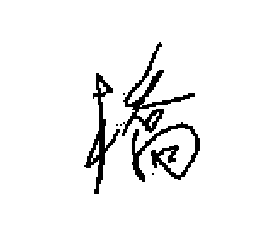

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #2 (False).


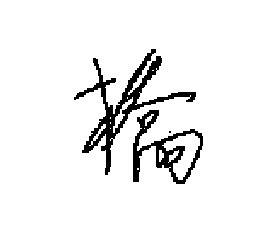

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #3 (False).


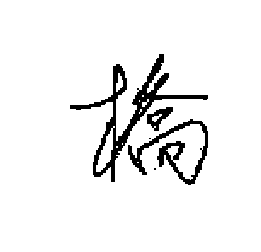

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #4 (False).


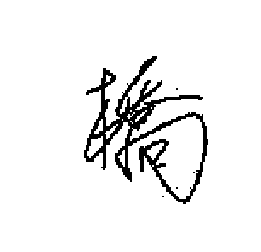

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #5 (False).


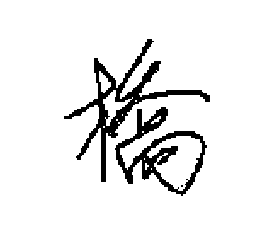

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #6 (False).


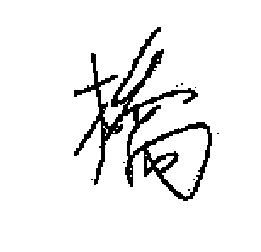

Successfully read #7 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


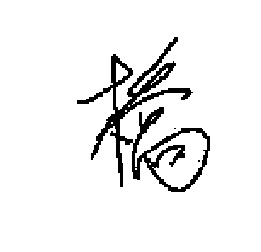

Successfully read #8 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


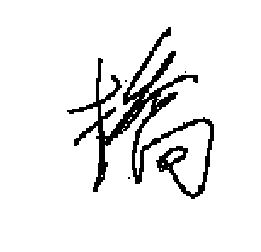

Successfully read #9 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


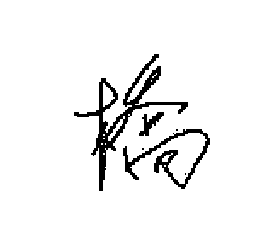

Successfully read #10 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


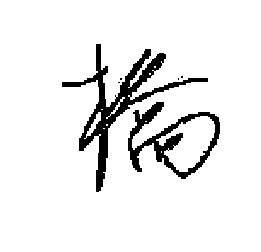

Successfully read #11 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


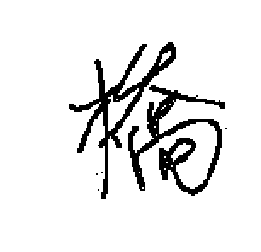

Successfully read #12 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


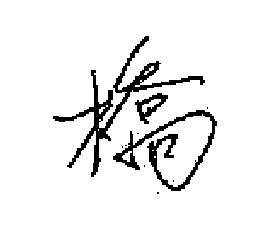

Successfully read #13 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


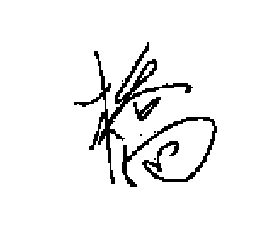

Successfully read #14 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


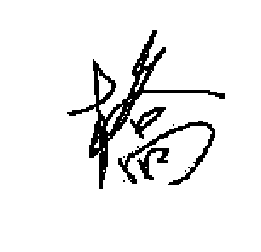

Successfully read #15 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


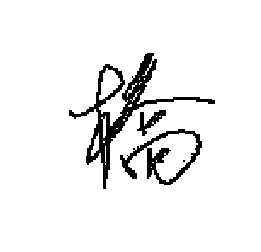

Successfully read #16 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


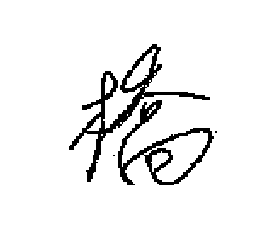

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #17 (False).


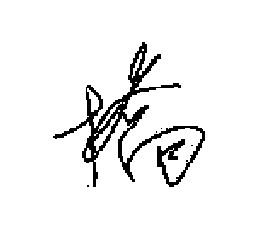

Successfully read #18 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


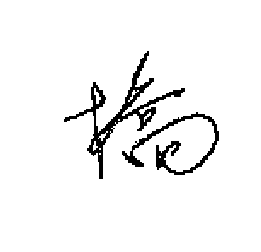

Successfully read #19 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


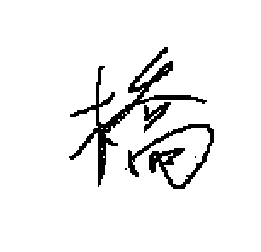

Successfully read #20 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


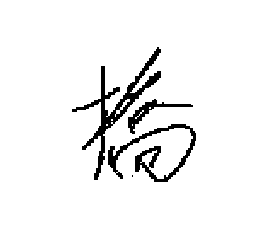

Successfully read #21 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


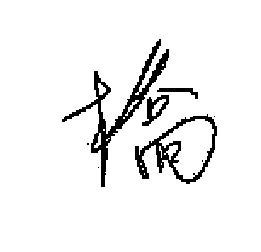

Successfully read #22 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


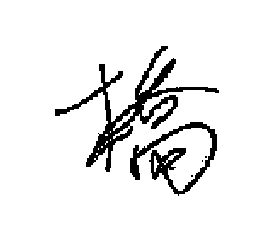

Successfully read #23 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


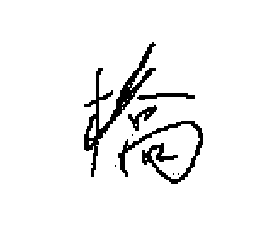

Successfully read #24 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


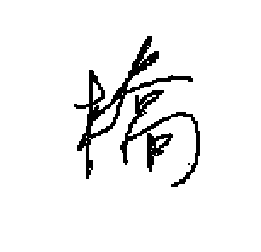

Successfully read #25 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


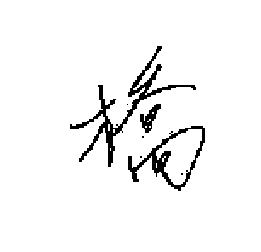

Successfully read #26 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


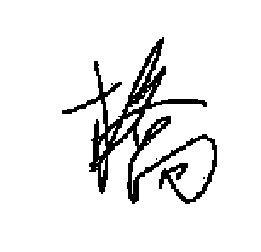

Successfully read #27 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


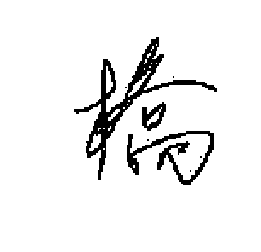

Successfully read #28 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


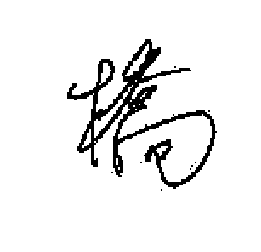

Successfully read #29 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


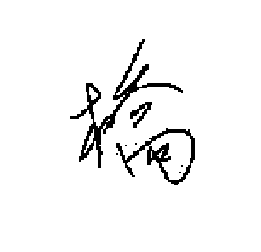

Successfully read #30 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


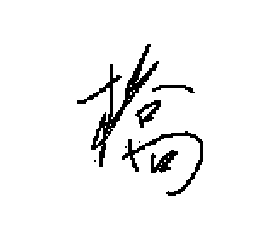

Successfully read #31 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


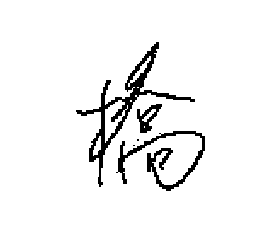

Successfully read #32 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


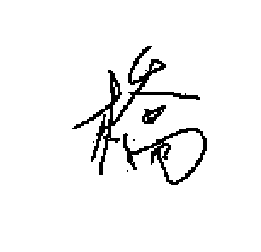

Successfully read #33 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


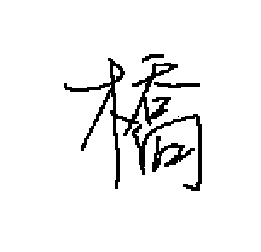

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #34 (False).


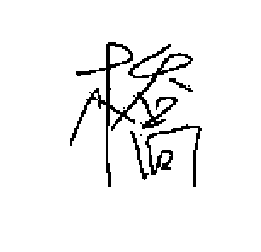

Successfully read #35 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


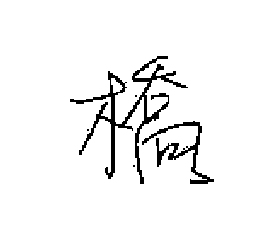

Successfully read #36 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


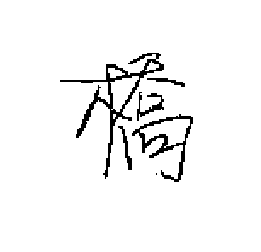

Successfully read #37 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


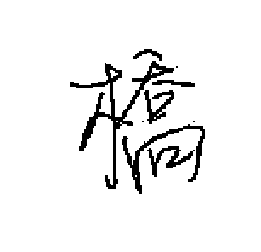

Successfully read #38 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


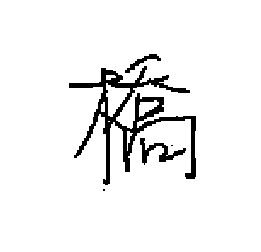

Successfully read #39 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


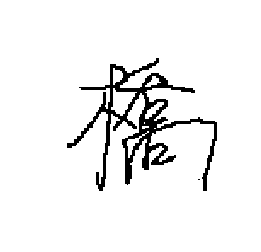

Successfully read #40 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


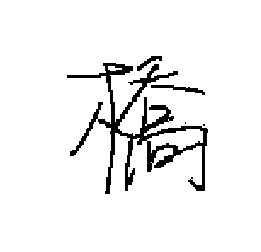

Successfully read #41 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


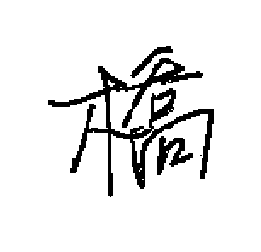

Successfully read #42 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


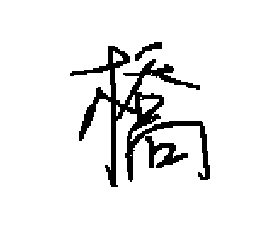

Successfully read #43 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


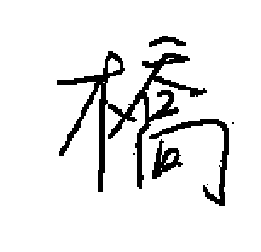

Successfully read #44 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


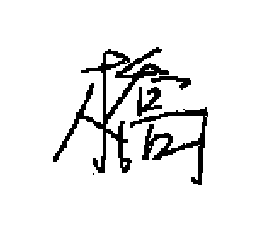

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #45 (False).


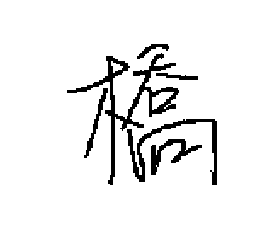

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #46 (False).


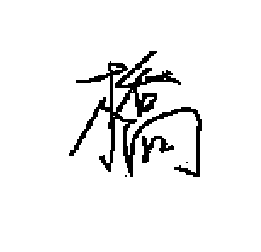

Successfully read #47 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


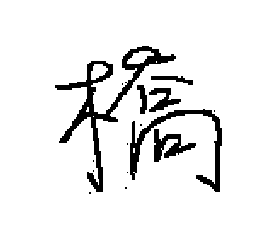

Successfully read #48 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


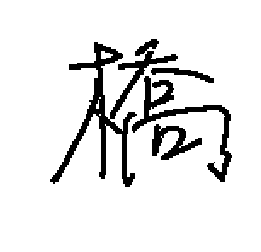

Successfully read #49 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


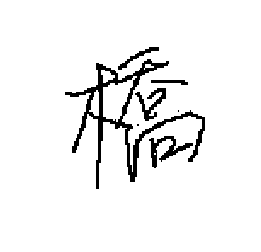

Successfully read #50 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


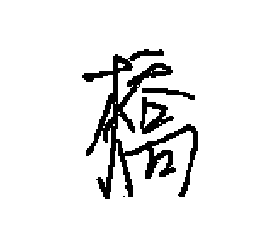

Successfully read #51 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


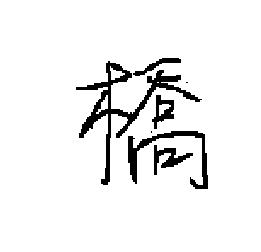

Successfully read #52 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


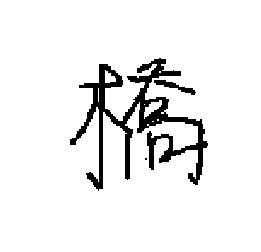

Successfully read #53 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


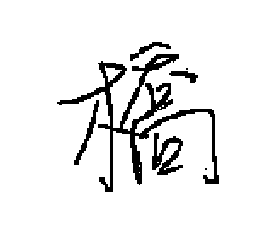

Successfully read #54 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


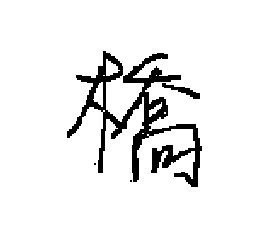

Successfully read #55 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


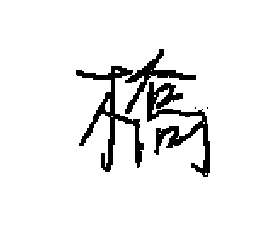

Successfully read #56 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


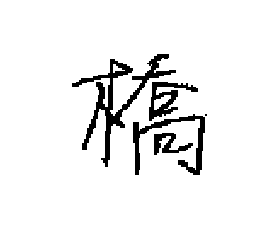

Successfully read #57 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


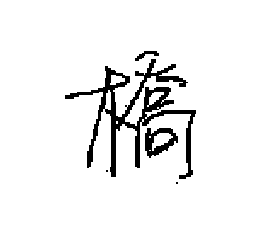

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #58 (False).


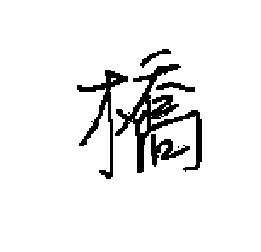

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #59 (False).


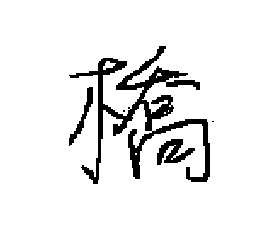

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #60 (False).


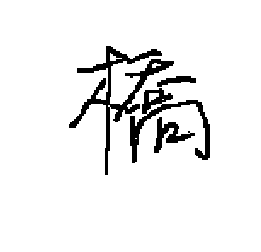

Successfully read #61 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


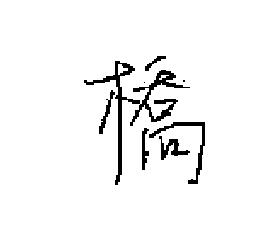

Successfully read #62 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


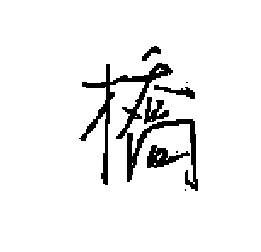

Successfully read #63 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


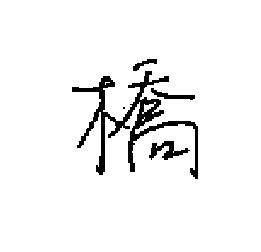

Successfully read #64 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


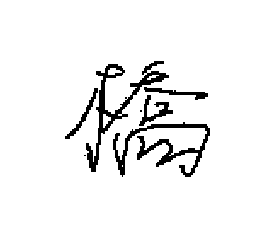

Successfully read #65 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


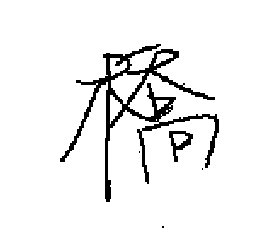

Successfully read #66 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


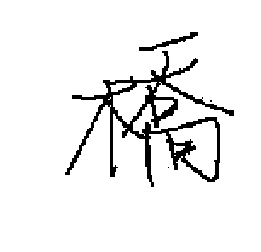

Successfully read #67 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


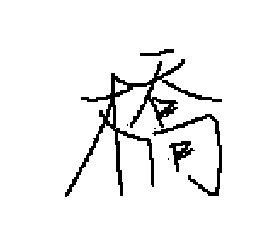

Successfully read #68 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


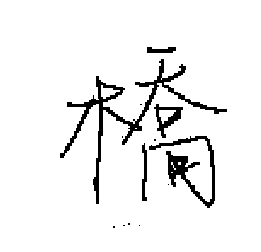

Successfully read #69 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


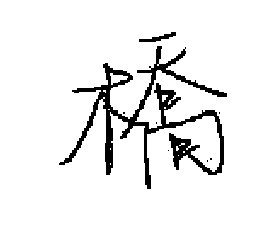

Successfully read #70 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


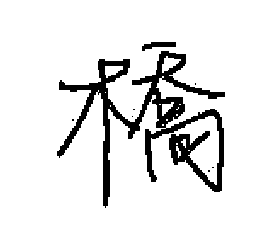

Successfully read #71 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


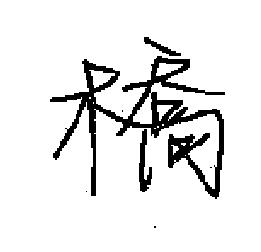

Successfully read #72 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


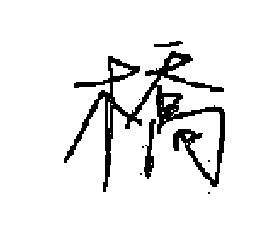

Successfully read #73 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


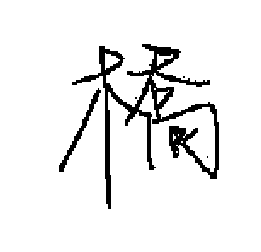

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #74 (False).


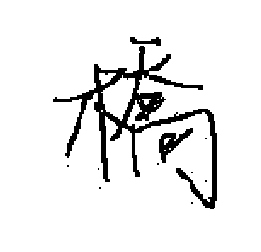

Successfully read #75 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


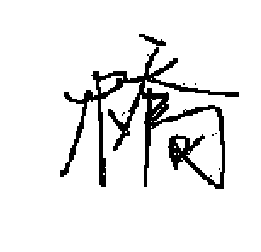

Successfully read #76 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


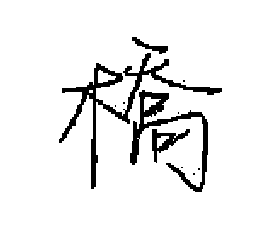

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #77 (False).


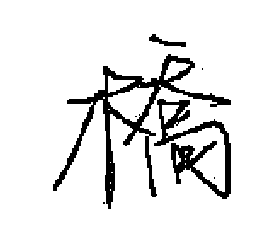

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #78 (False).


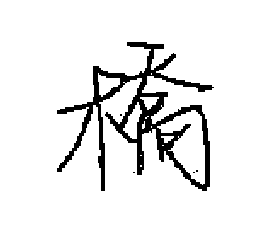

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #79 (False).


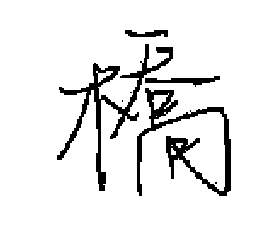

Successfully read #80 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


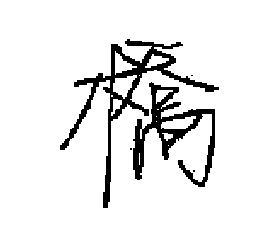

Successfully read #81 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


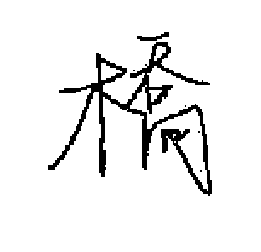

Successfully read #82 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


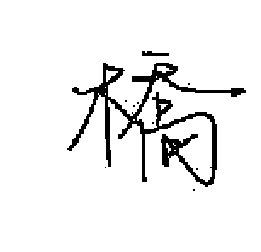

Successfully read #83 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


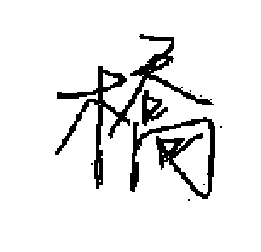

Successfully read #84 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


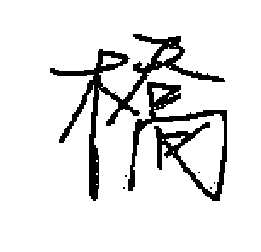

Successfully read #85 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


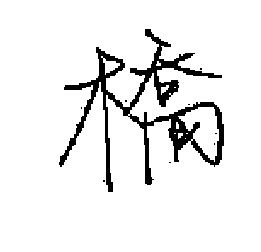

Successfully read #86 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


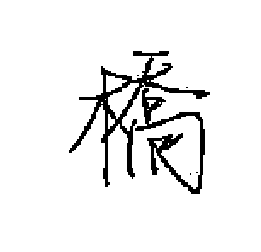

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #87 (False).


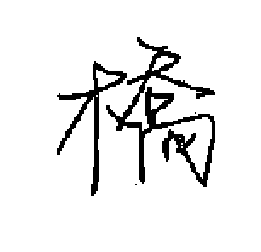

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #88 (False).


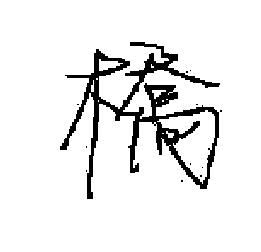

Successfully read #89 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


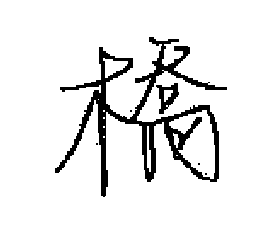

Successfully read #90 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


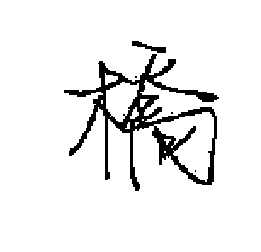

Successfully read #91 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


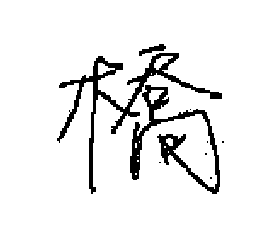

Successfully read #92 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


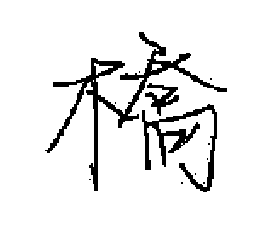

Successfully read #93 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


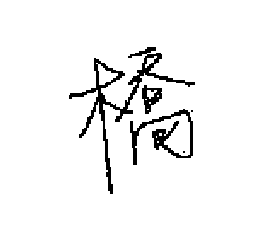

Successfully read #94 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


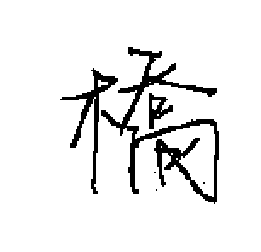

Successfully read #95 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


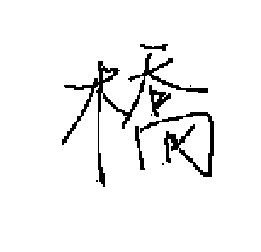

Successfully read #96 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


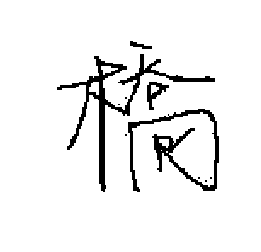

Successfully read #97 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


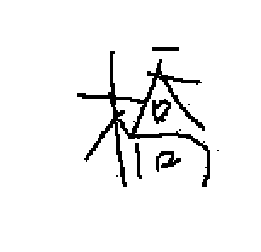

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #98 (False).


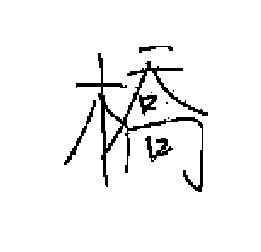

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #99 (False).


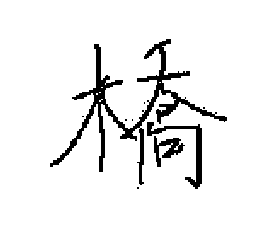

Successfully read #100 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


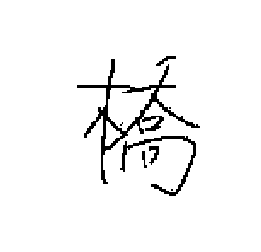

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #101 (False).


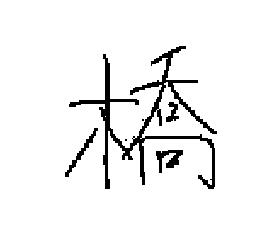

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #102 (False).


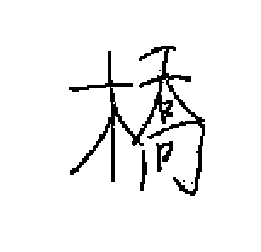

Successfully read #103 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


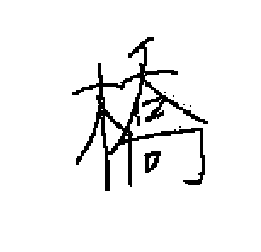

Successfully read #104 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


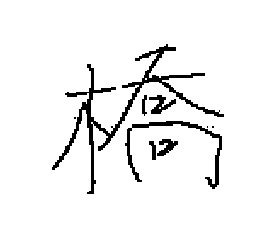

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #105 (False).


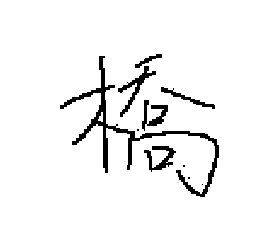

Successfully read #106 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


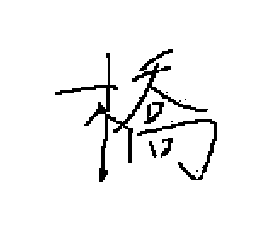

Successfully read #107 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


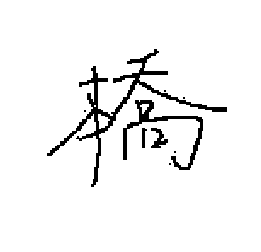

Successfully read #108 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


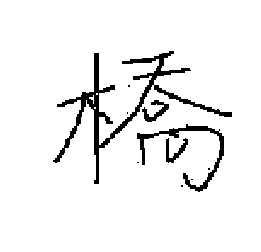

Successfully read #109 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


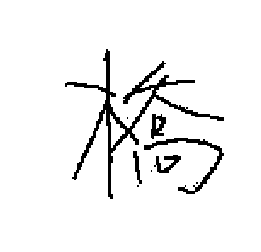

Successfully read #110 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


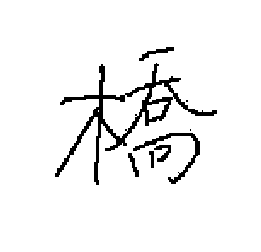

Successfully read #111 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


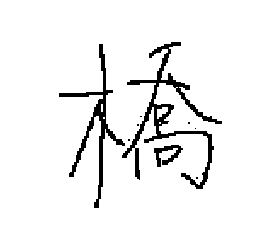

Successfully read #112 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


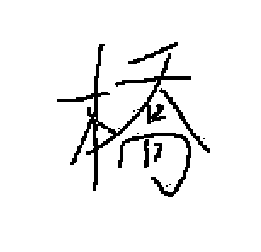

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #113 (False).


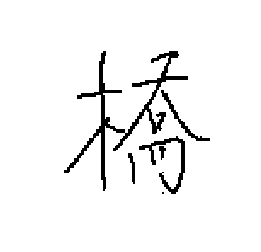

Successfully read #114 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


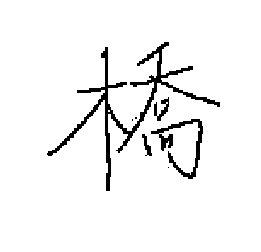

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #115 (False).


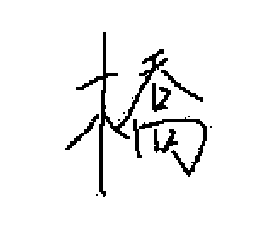

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #116 (False).


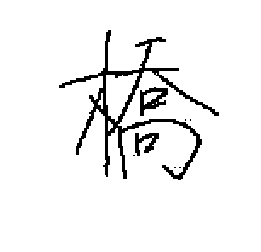

Successfully read #117 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


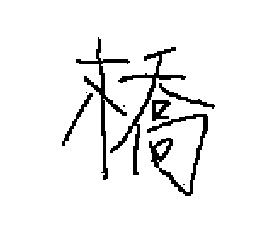

Successfully read #118 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


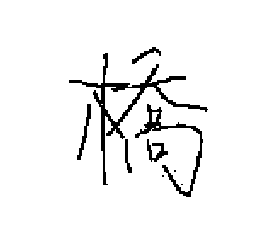

Successfully read #119 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


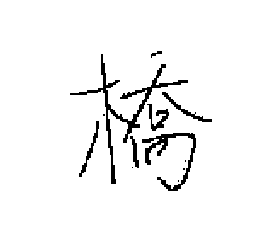

Successfully read #120 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


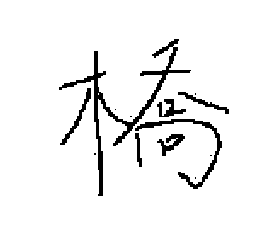

Successfully read #121 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


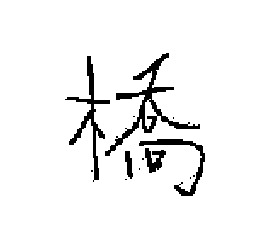

Successfully read #122 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


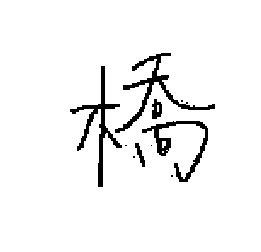

Successfully read #123 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


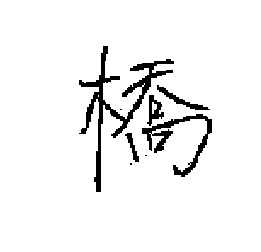

Successfully read #124 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


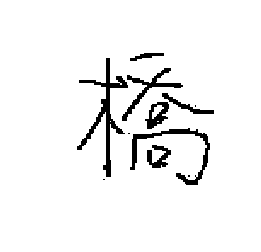

Successfully read #125 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


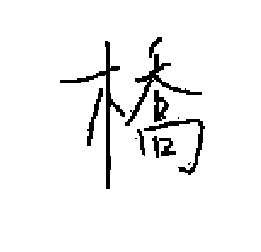

Successfully read #126 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


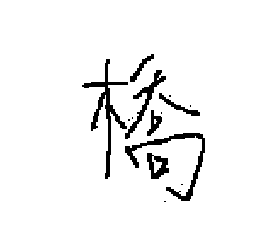

Successfully read #127 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


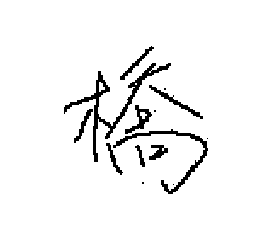

Successfully read #128 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


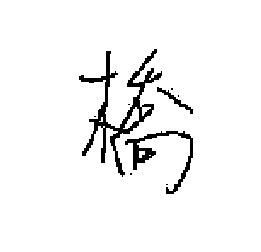

Successfully read #129 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


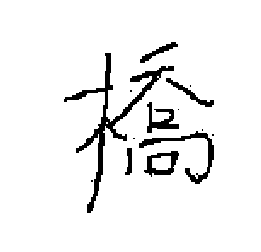

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #130 (False).


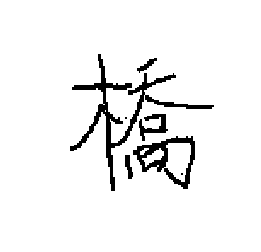

Successfully read #131 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


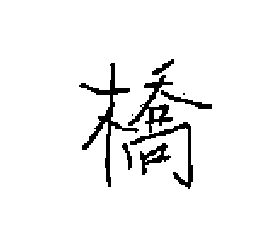

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #132 (False).


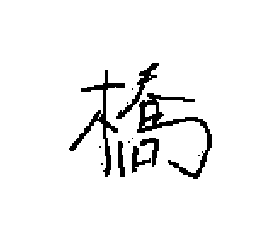

Successfully read #133 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


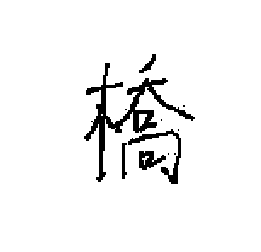

Successfully read #134 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


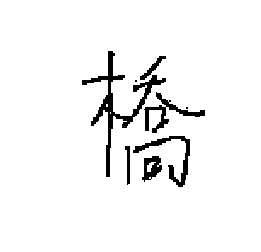

Successfully read #135 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


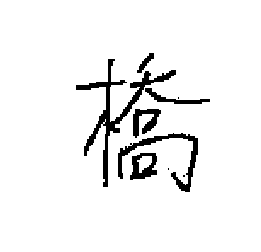

Successfully read #136 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


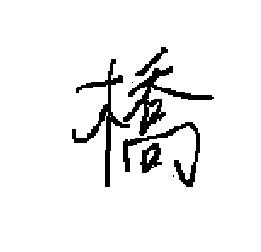

Successfully read #137 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


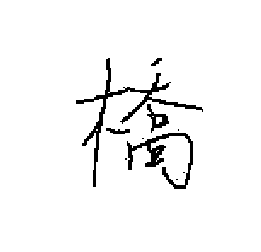

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #138 (False).


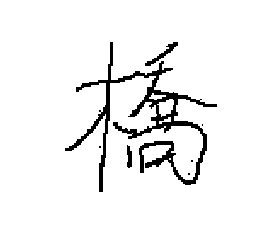

Successfully read #139 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


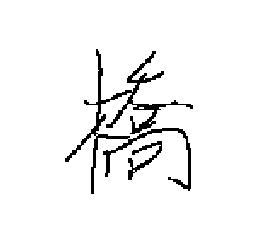

Successfully read #140 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


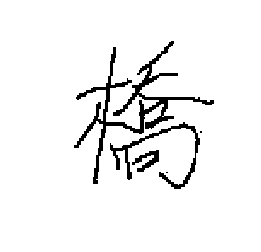

Successfully read #141 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


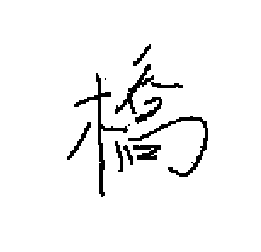

Successfully read #142 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


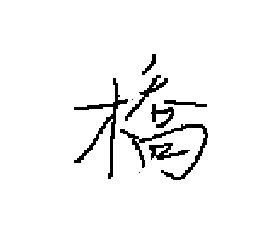

Successfully read #143 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


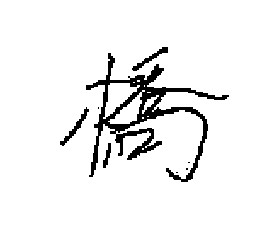

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #144 (False).


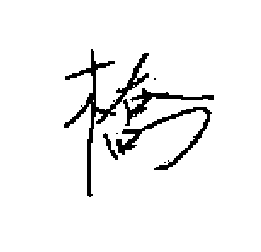

Successfully read #145 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


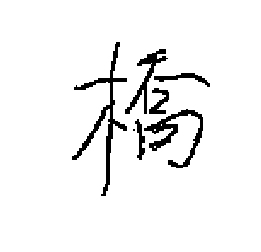

Successfully read #146 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


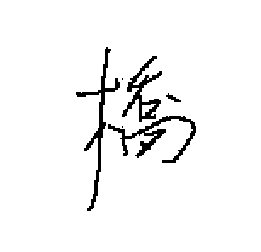

Successfully read #147 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


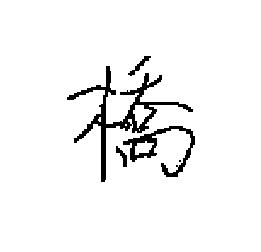

Successfully read #148 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


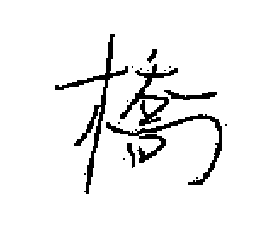

Successfully read #149 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


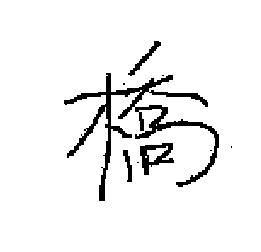

Successfully read #150 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


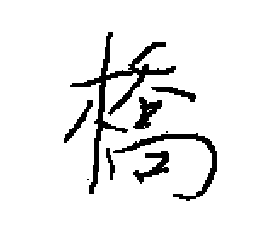

Successfully read #151 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


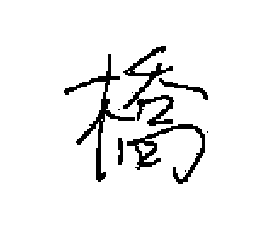

Successfully read #152 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


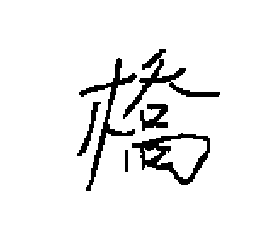

Successfully read #153 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


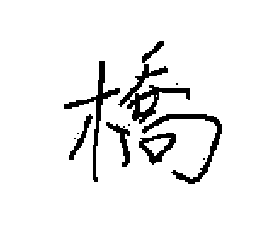

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #154 (False).


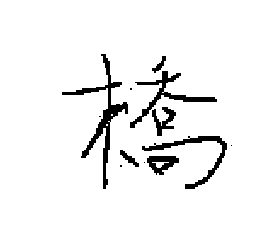

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #155 (False).


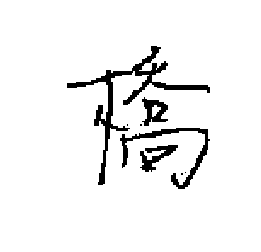

Successfully read #156 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


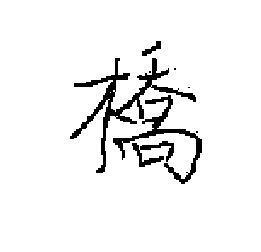

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #157 (False).


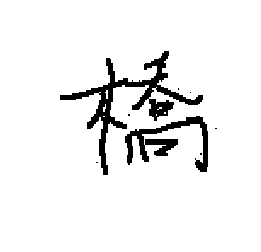

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #158 (False).


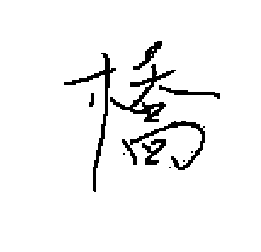

Successfully read #159 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


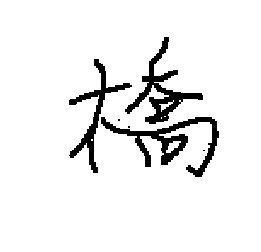

Successfully read #160 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


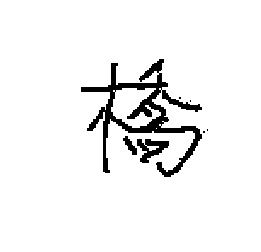

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #161 (False).


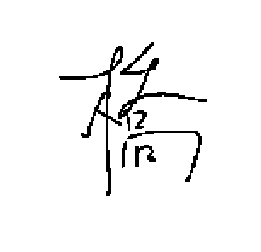

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #162 (False).


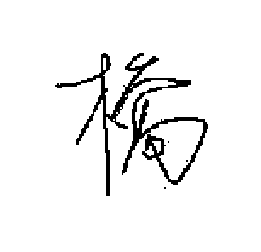

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #163 (False).


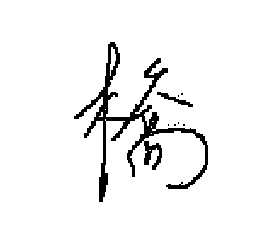

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #164 (False).


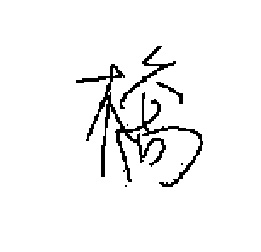

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #165 (False).


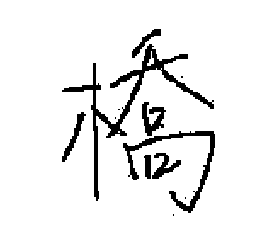

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #166 (False).


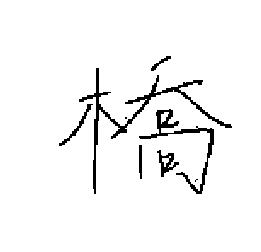

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #167 (False).


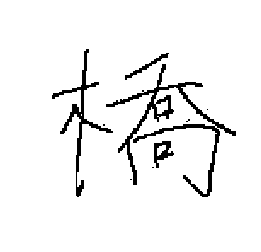

Successfully read #168 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


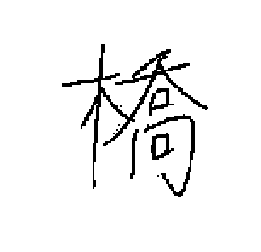

Successfully read #169 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


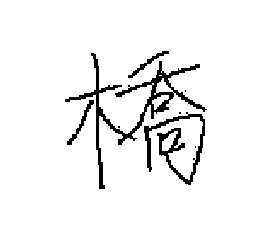

Successfully read #170 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


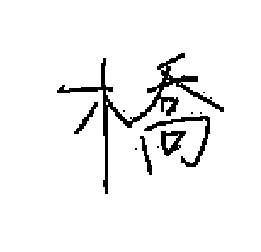

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #171 (False).


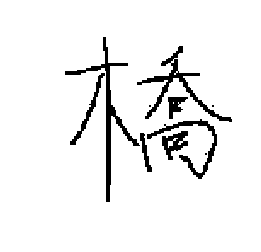

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #172 (False).


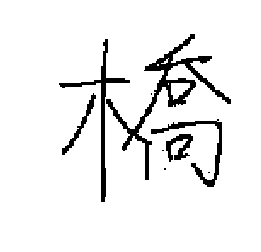

Successfully read #173 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


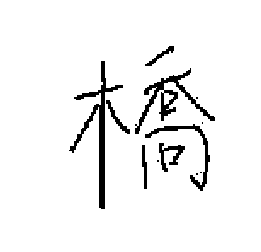

Successfully read #174 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


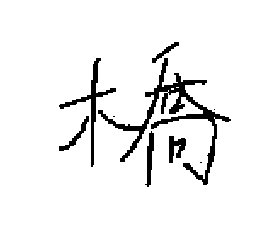

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #175 (False).


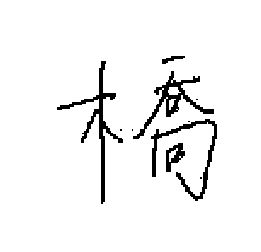

Successfully read #176 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


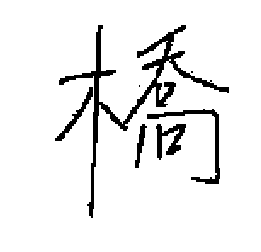

Successfully read #177 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


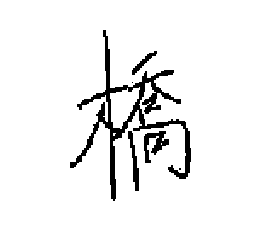

Successfully read #178 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


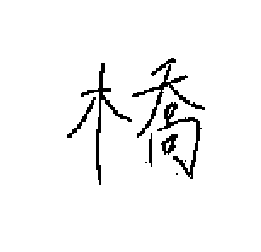

Successfully read #179 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


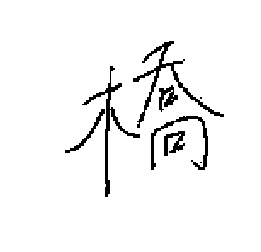

Successfully read #180 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


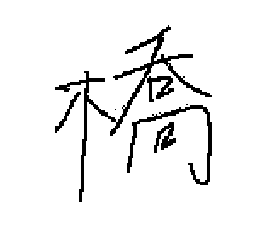

Successfully read #181 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


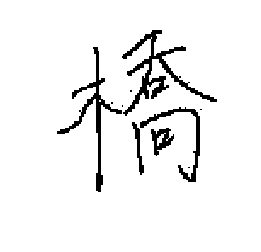

Successfully read #182 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


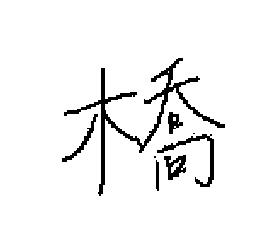

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #183 (False).


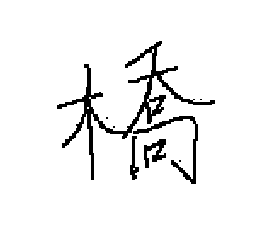

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #184 (False).


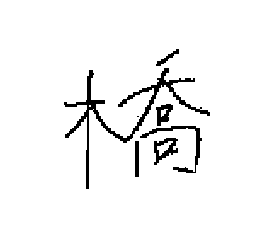

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #185 (False).


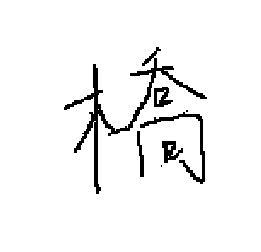

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #186 (False).


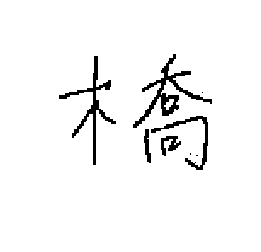

Successfully read #187 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


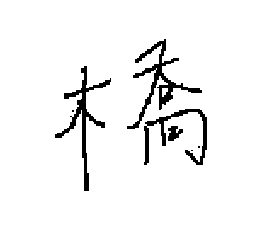

Successfully read #188 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


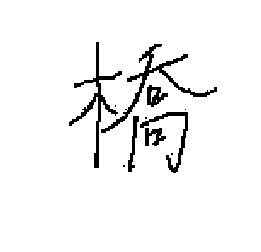

Successfully read #189 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


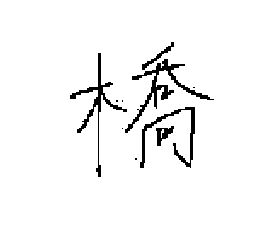

Successfully read #190 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


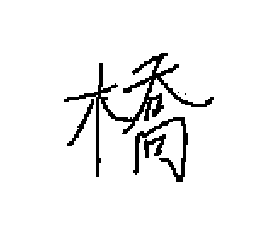

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #191 (False).


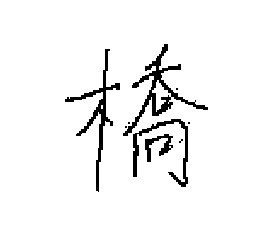

Successfully read #192 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


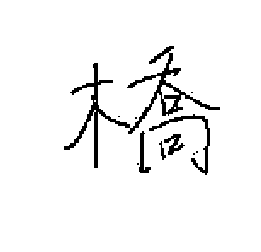

Successfully read #193 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


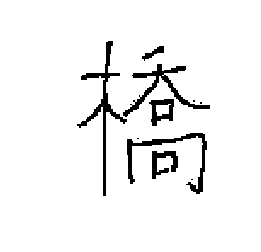

Successfully read #194 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


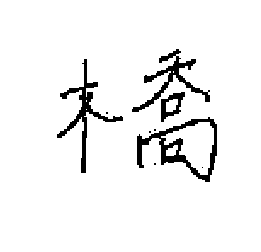

Successfully read #195 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


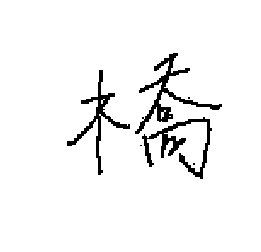

Successfully read #196 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


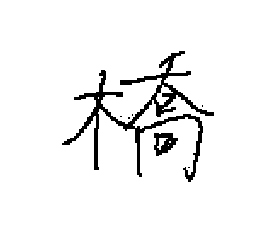

Successfully read #197 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


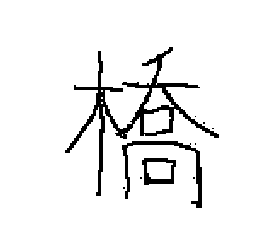

Successfully read #198 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


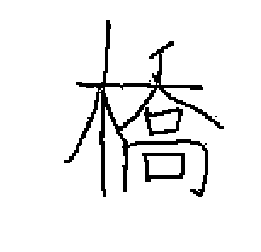

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #199 (False).


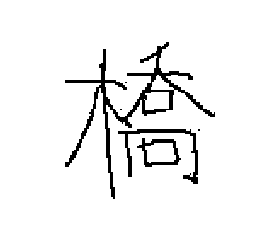

Successfully read #200 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


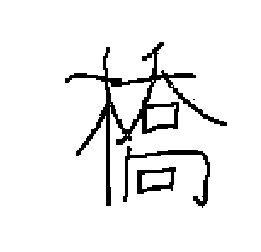

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #201 (False).


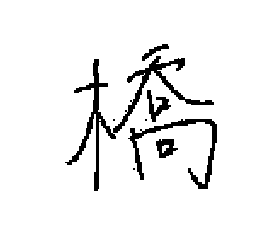

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #202 (False).


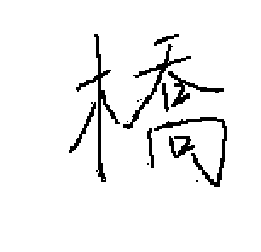

Successfully read #203 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


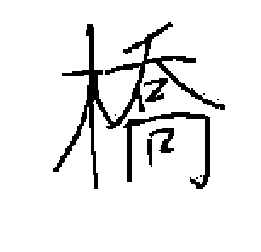

Successfully read #204 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


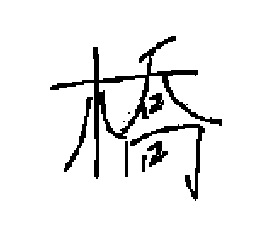

Successfully read #205 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


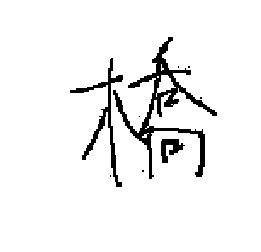

Successfully read #206 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


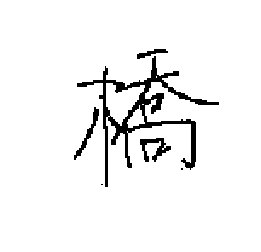

Successfully read #207 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


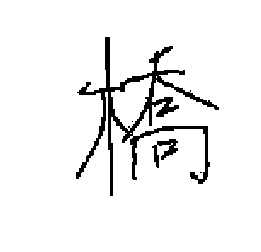

Successfully read #208 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


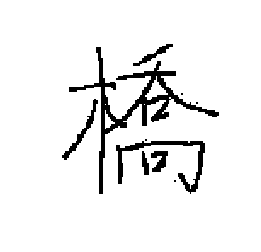

Successfully read #209 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


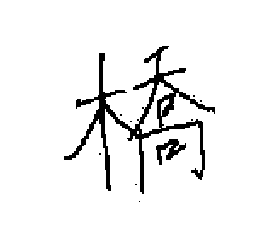

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #210 (False).


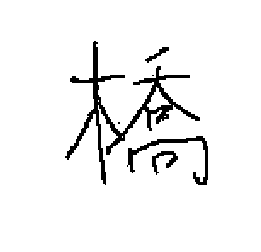

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #211 (False).


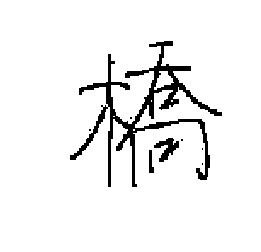

Successfully read #212 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


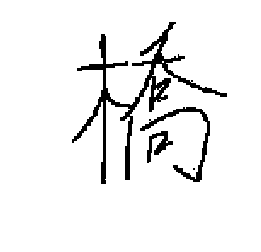

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #213 (False).


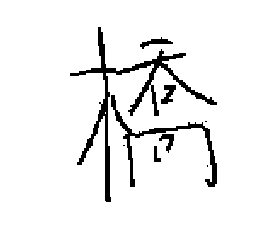

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #214 (False).


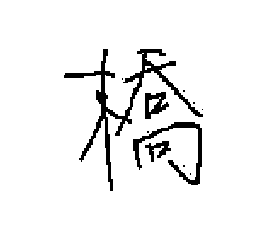

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #215 (False).


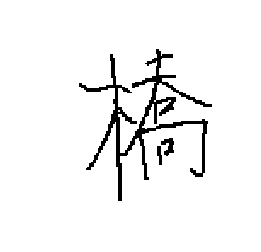

Successfully read #216 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


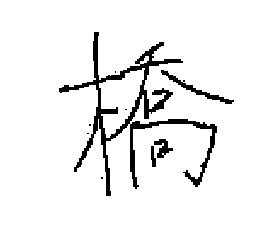

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #217 (False).


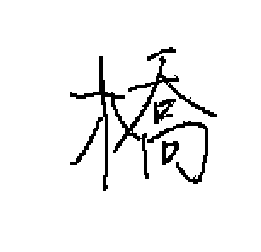

Successfully read #218 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


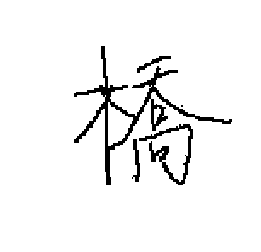

Successfully read #219 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


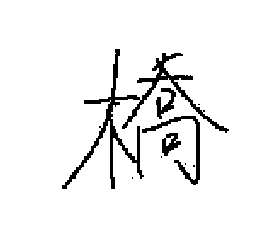

Successfully read #220 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


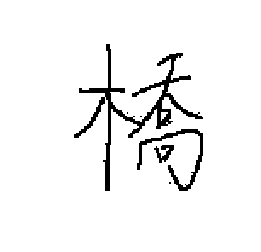

Successfully read #221 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


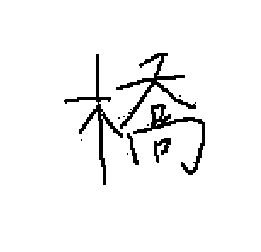

Successfully read #222 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


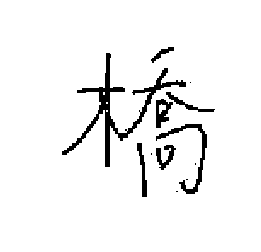

Successfully read #223 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


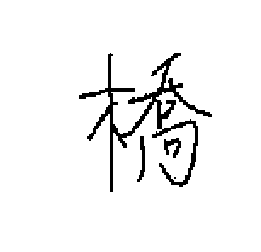

Successfully read #224 (False).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


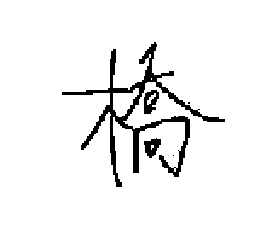

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #225 (True).


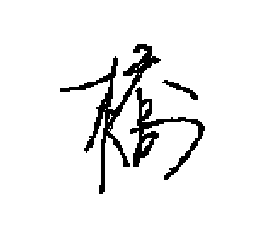

Successfully read #226 (True).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


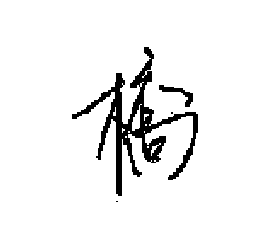

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #227 (True).


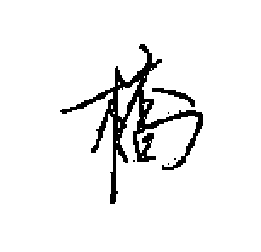

Successfully read #228 (True).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


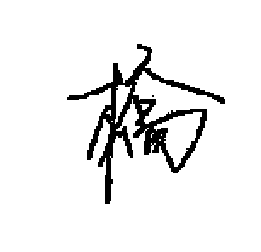

Successfully read #229 (True).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


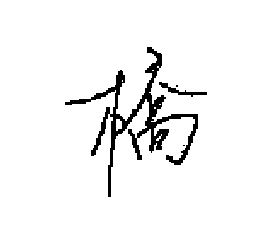

Successfully read #230 (True).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


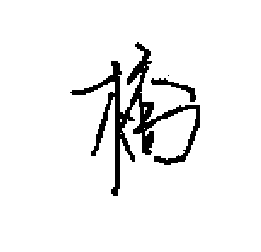

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #231 (True).


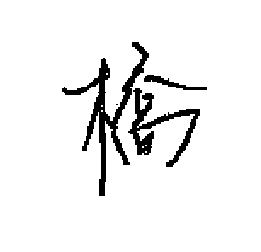

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #232 (True).


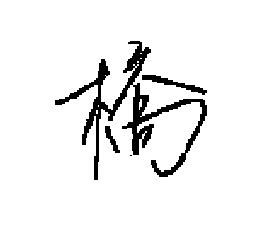

Successfully read #233 (True).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


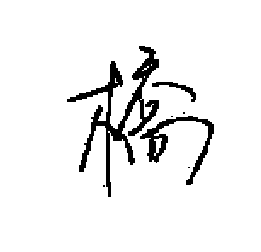

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #234 (True).


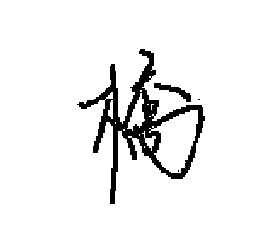

Successfully read #235 (True).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


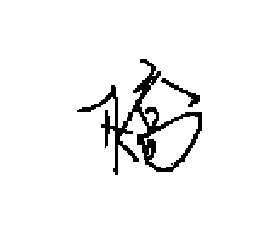

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #236 (True).


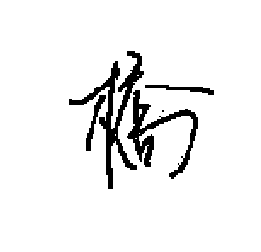

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #237 (True).


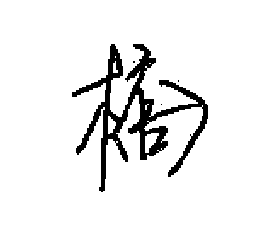

Successfully read #238 (True).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


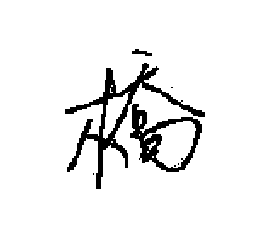

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #239 (True).


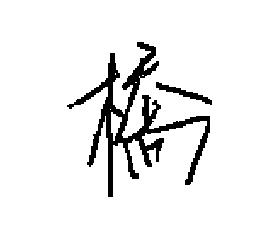

Successfully read #240 (True).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


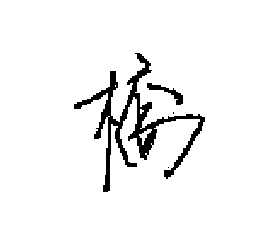

Successfully read #241 (True).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


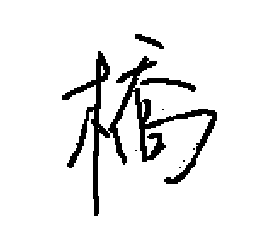

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #242 (True).


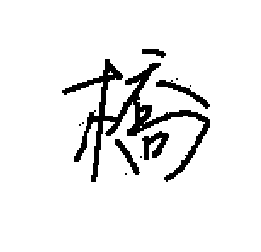

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #243 (True).


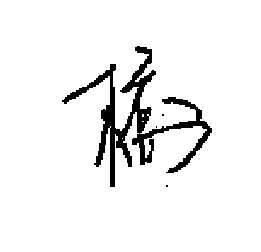

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #244 (True).


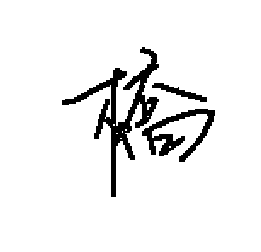

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #245 (True).


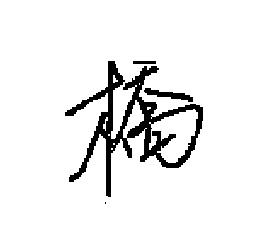

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #246 (True).


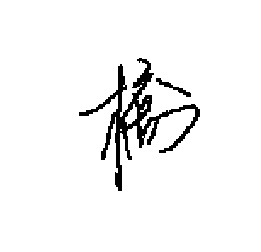

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #247 (True).


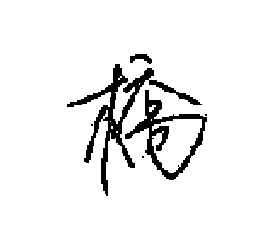

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #248 (True).


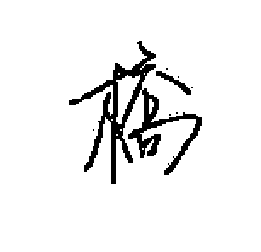

Successfully read #249 (True).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


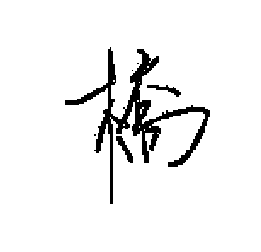

Successfully read #250 (True).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


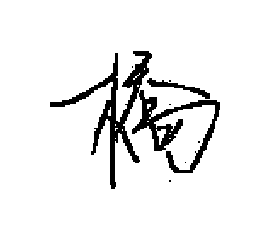

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #251 (True).


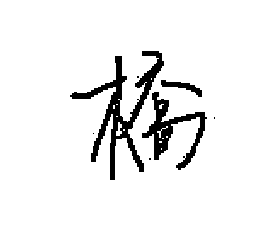

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #252 (True).


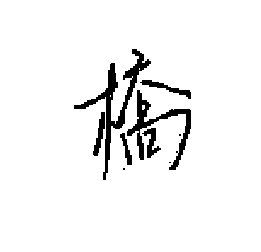

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #253 (True).


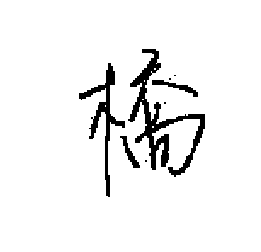

Successfully read #254 (True).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


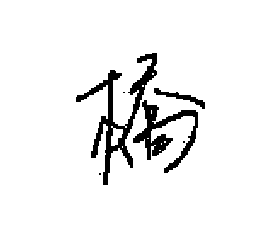

Successfully read #255 (True).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


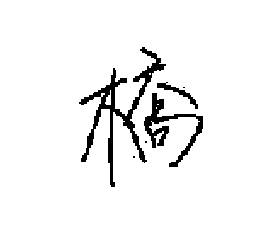

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #256 (True).


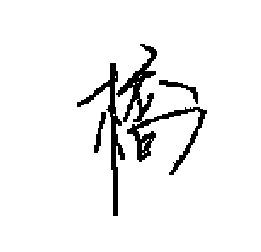

Successfully read #257 (True).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


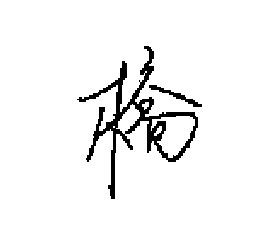

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #258 (True).


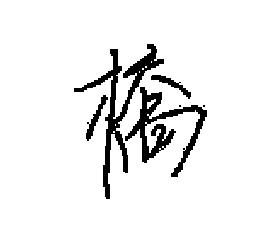

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #259 (True).


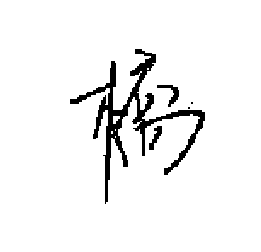

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #260 (True).


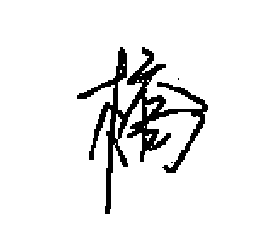

Successfully read #261 (True).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


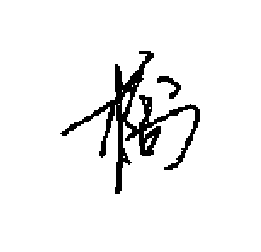

Successfully read #262 (True).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


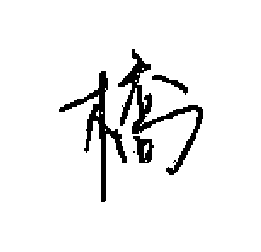

Successfully read #263 (True).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


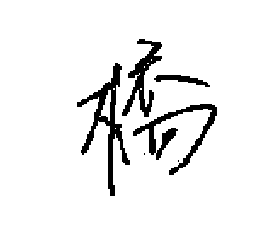

Successfully read #264 (True).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


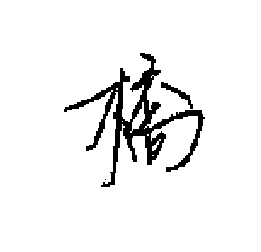

Successfully read #265 (True).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


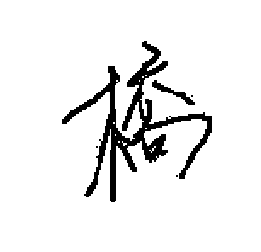

Successfully read #266 (True).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


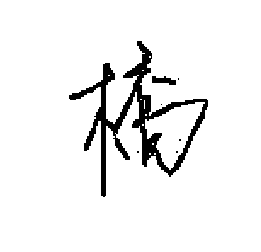

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #267 (True).


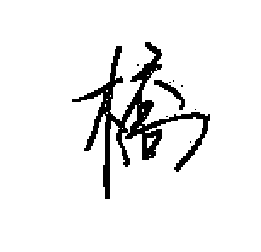

Successfully read #268 (True).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


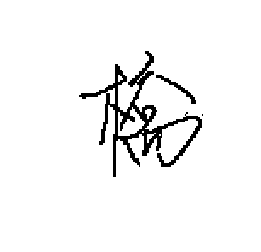

Successfully read #269 (True).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


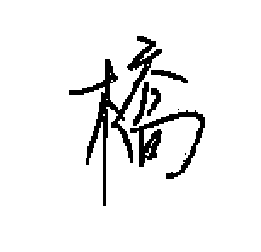

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #270 (True).


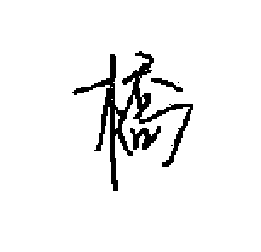

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #271 (True).


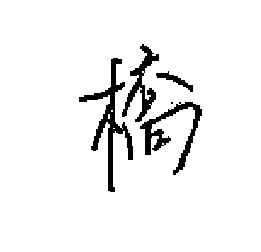

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #272 (True).


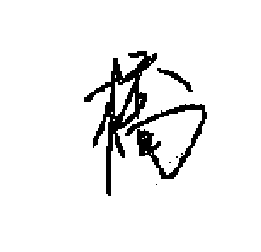

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #273 (True).


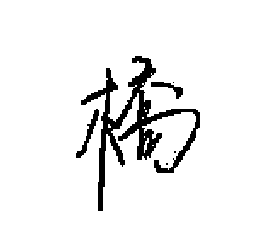

Successfully read #274 (True).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


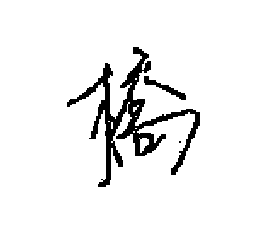

Successfully read #275 (True).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


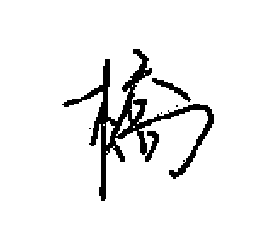

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #276 (True).


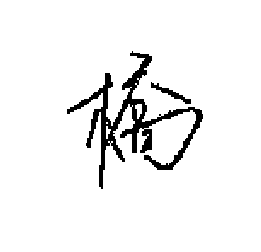

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #277 (True).


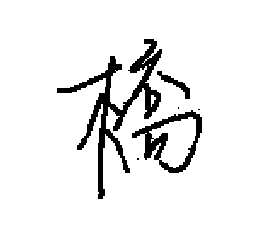

Successfully read #278 (True).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


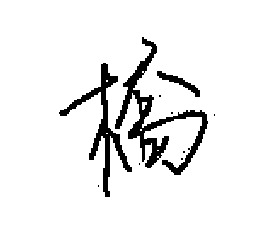

Successfully read #279 (True).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


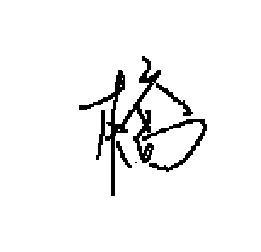

Successfully read #280 (True).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


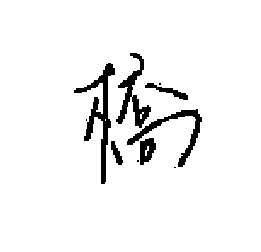

Successfully read #281 (True).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


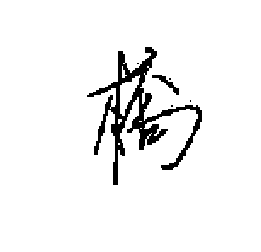

Successfully read #282 (True).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


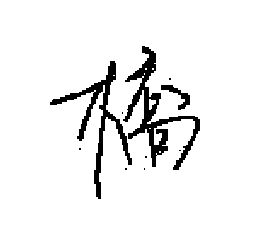

Successfully read #283 (True).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


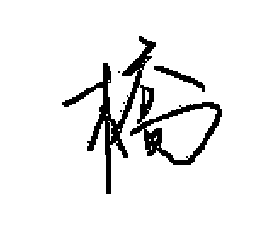

Successfully read #284 (True).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


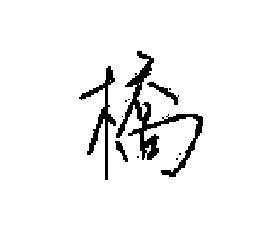

Successfully read #285 (True).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


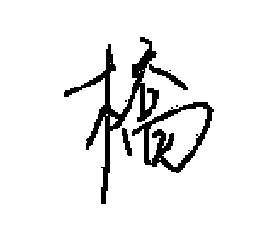

Successfully read #286 (True).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


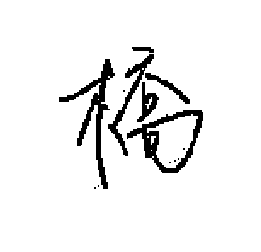

Successfully read #287 (True).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


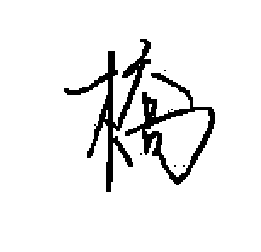

Successfully read #288 (True).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


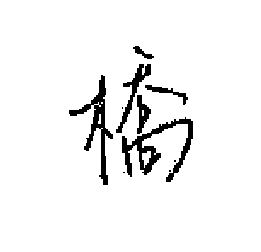

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #289 (True).


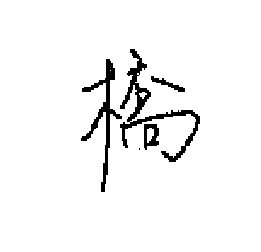

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #290 (True).


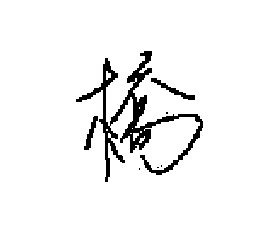

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #291 (True).


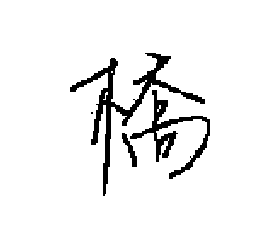

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #292 (True).


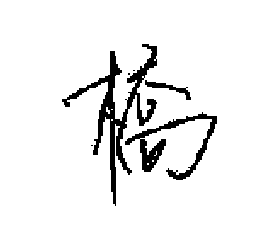

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #293 (True).


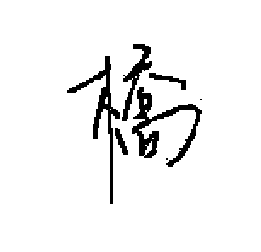

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #294 (True).


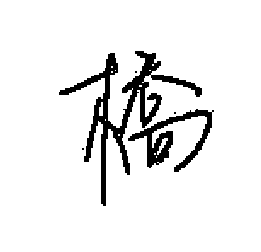

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #295 (True).


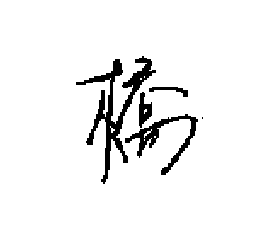

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #296 (True).


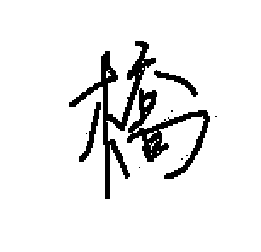

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #297 (True).


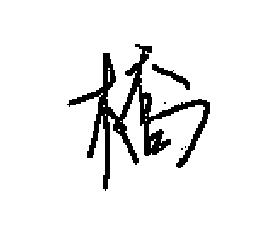

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #298 (True).


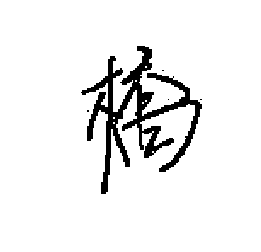

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #299 (True).


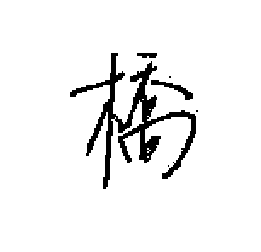

Successfully read #300 (True).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


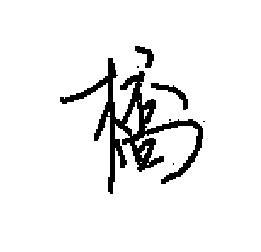

Successfully read #301 (True).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


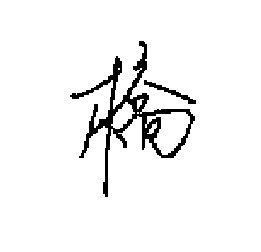

Successfully read #302 (True).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


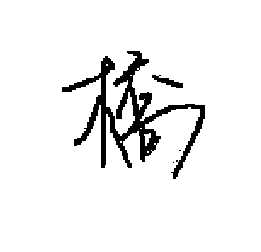

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #303 (True).


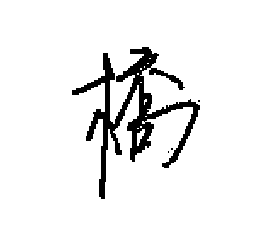

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #304 (True).


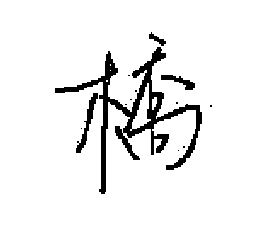

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #305 (True).


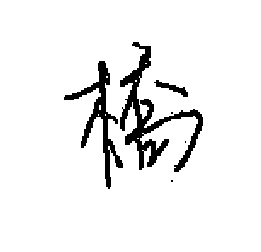

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #306 (True).


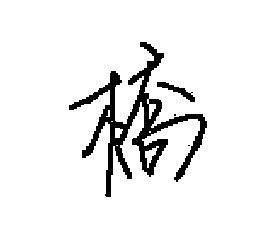

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #307 (True).


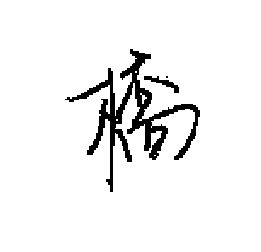

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #308 (True).


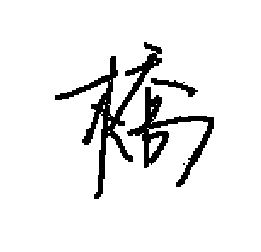

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #309 (True).


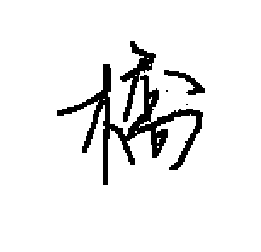

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #310 (True).


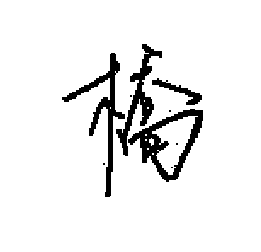

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #311 (True).


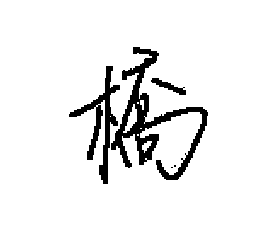

Successfully read #312 (True).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


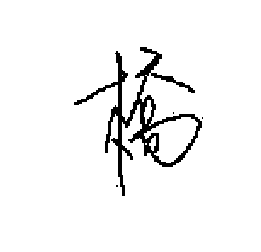

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #313 (True).


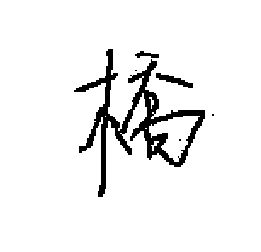

Successfully read #314 (True).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


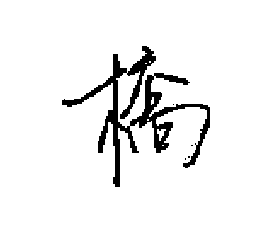

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #315 (True).


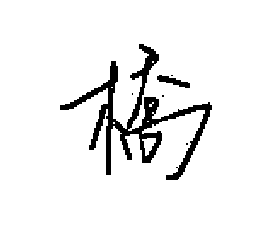

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #316 (True).


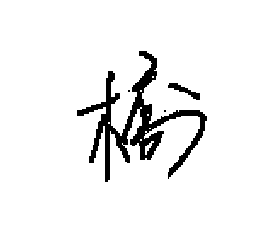

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #317 (True).


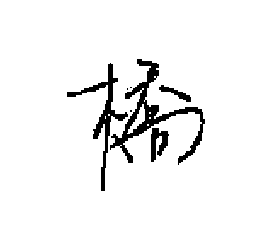

Successfully read #318 (True).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


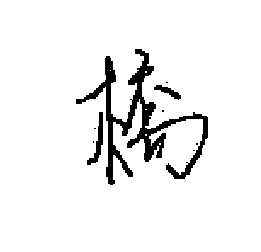

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #319 (True).


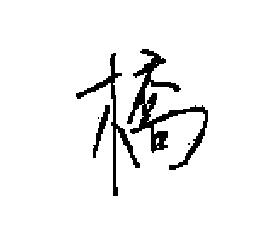

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #320 (True).


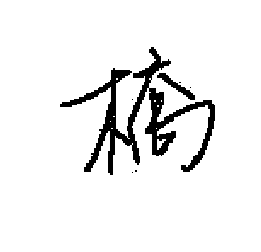

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #321 (True).


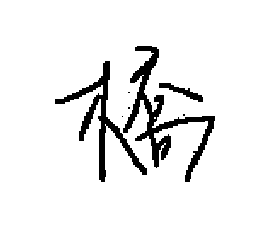

Successfully read #322 (True).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


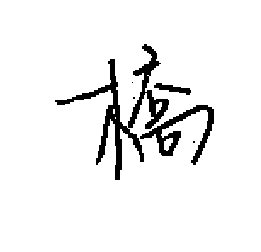

Successfully read #323 (True).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


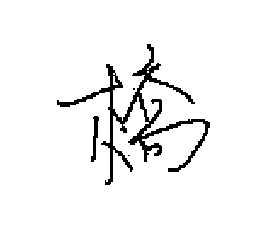

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #324 (True).


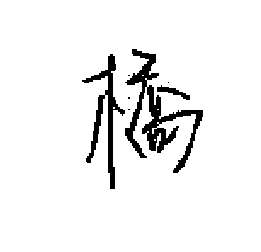

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #325 (True).


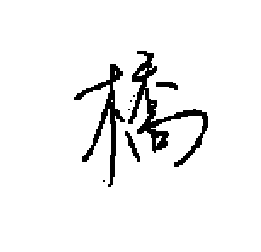

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #326 (True).


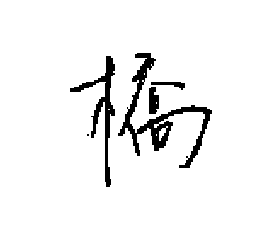

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #327 (True).


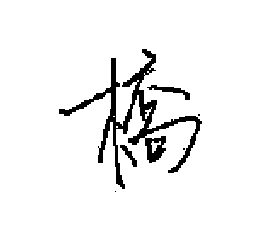

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #328 (True).


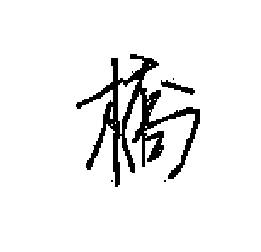

Successfully read #329 (True).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


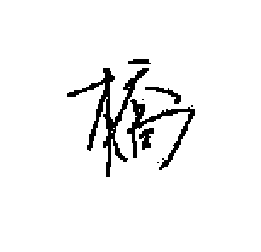

Successfully read #330 (True).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


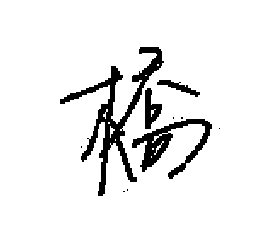

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #331 (True).


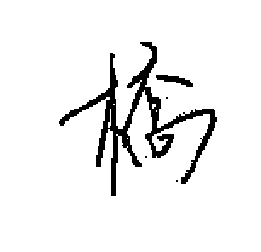

Successfully read #332 (True).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


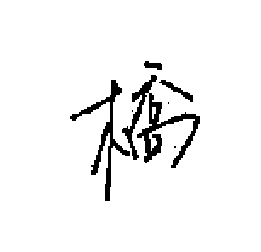

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #333 (True).


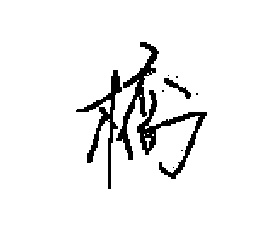

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #334 (True).


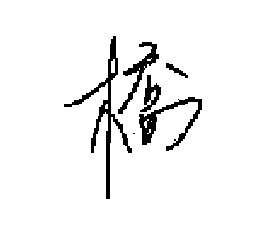

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #335 (True).


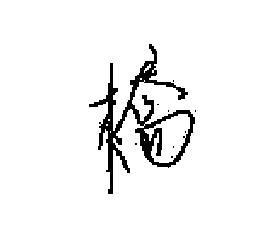

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #336 (True).


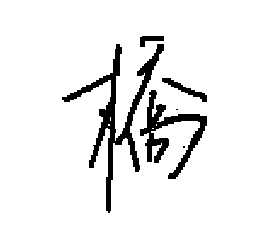

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #337 (True).


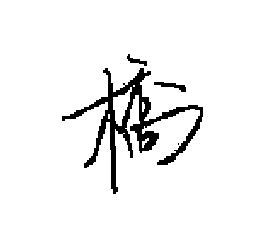

Successfully read #338 (True).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


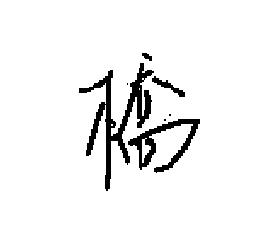

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #339 (True).


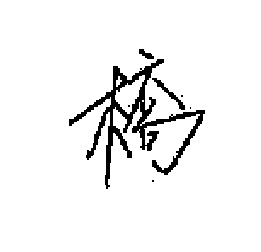

Successfully read #340 (True).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


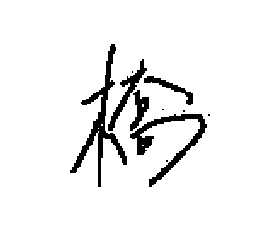

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #341 (True).


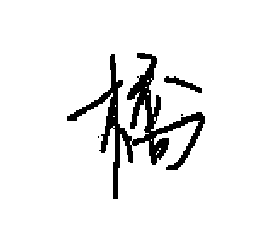

Successfully read #342 (True).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


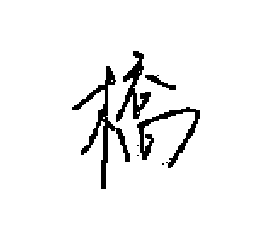

Successfully read #343 (True).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


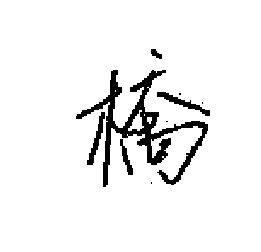

Successfully read #344 (True).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


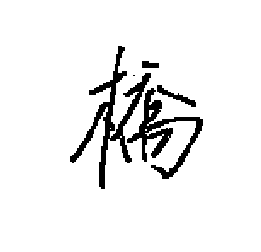

Successfully read #345 (True).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


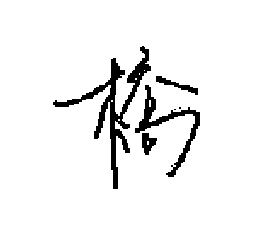

Successfully read #346 (True).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


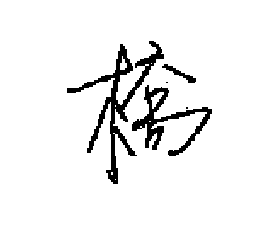

Successfully read #347 (True).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


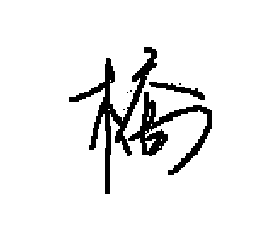

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #348 (True).


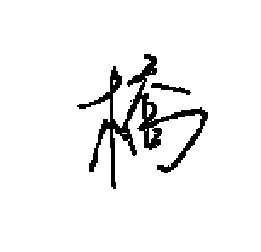

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #349 (True).


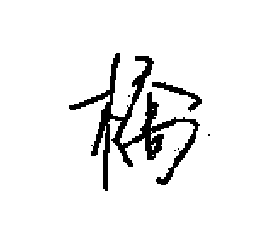

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #350 (True).


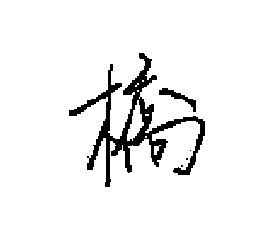

Successfully read #351 (True).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


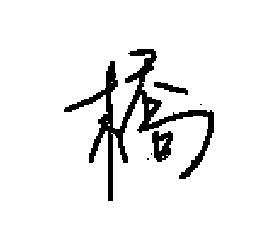

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #352 (True).


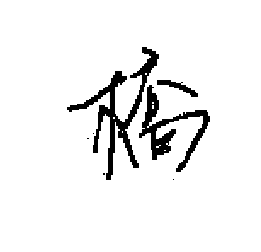

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #353 (True).


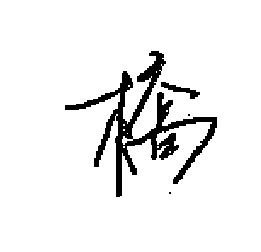

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #354 (True).


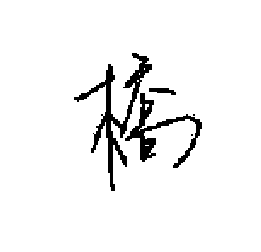

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #355 (True).


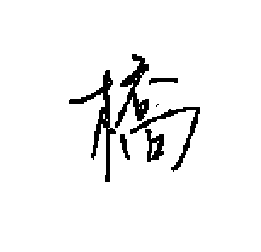

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #356 (True).


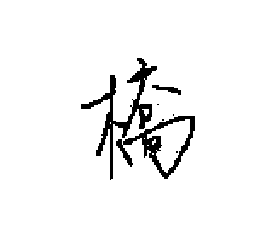

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #357 (True).


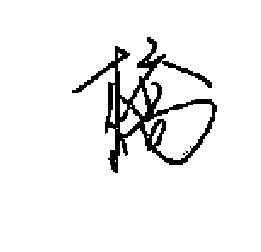

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #358 (True).


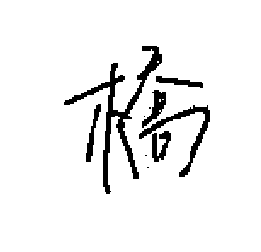

Successfully read #359 (True).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


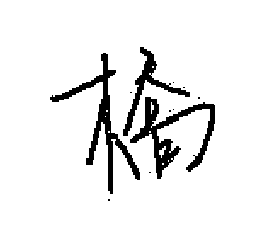

Successfully read #360 (True).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


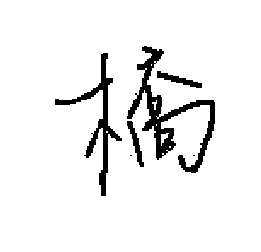

Successfully read #361 (True).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


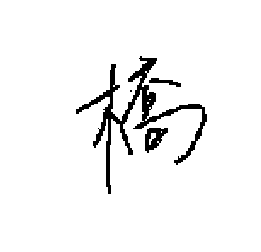

Successfully read #362 (True).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


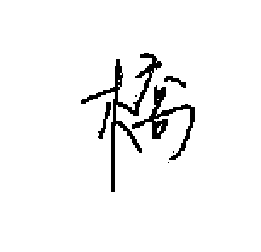

Successfully read #363 (True).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


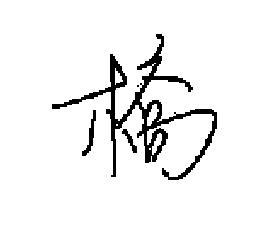

Successfully read #364 (True).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


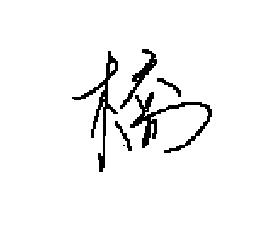

Successfully read #365 (True).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


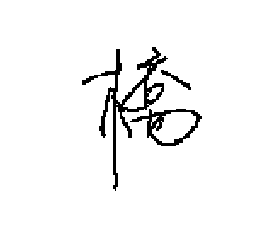

Successfully read #366 (True).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


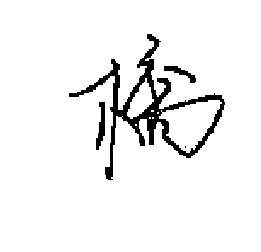

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #367 (True).


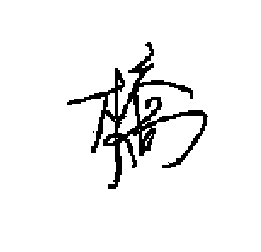

Successfully read #368 (True).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


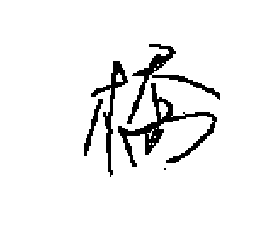

Successfully read #369 (True).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


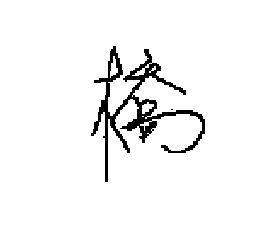

Successfully read #370 (True).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


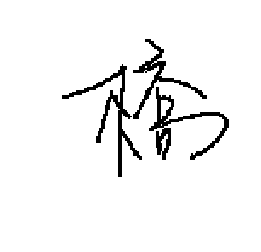

Successfully read #371 (True).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


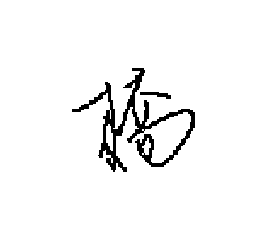

Successfully read #372 (True).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


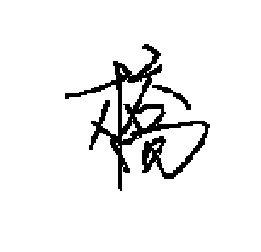

Successfully read #373 (True).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


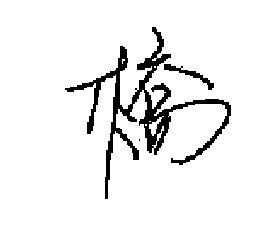

Successfully read #374 (True).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


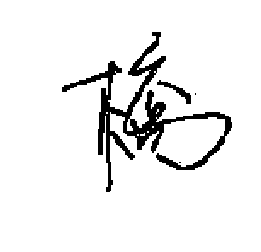

Successfully read #375 (True).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


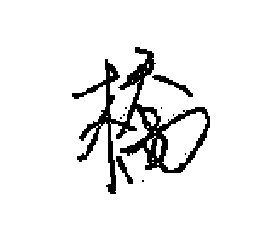

Successfully read #376 (True).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


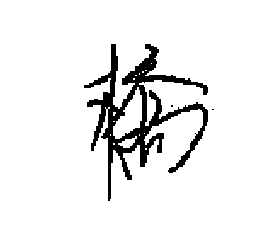

Successfully read #377 (True).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


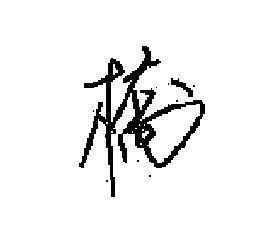

Successfully read #378 (True).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


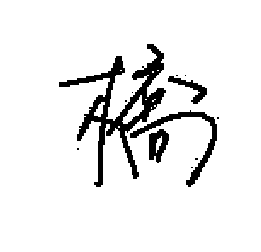

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #379 (True).


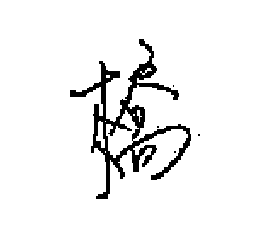

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #380 (True).


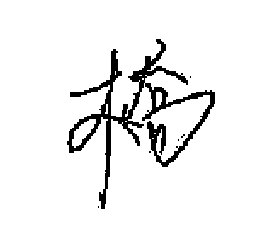

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #381 (True).


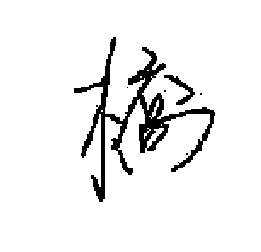

Successfully read #382 (True).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


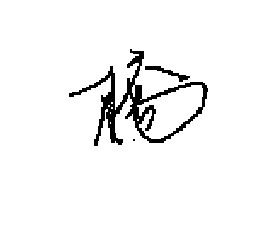

Successfully read #383 (True).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


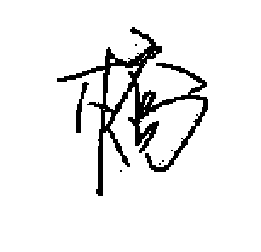

Successfully read #384 (True).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


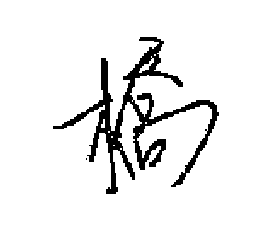

Successfully read #385 (True).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


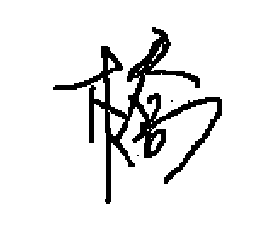

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #386 (True).


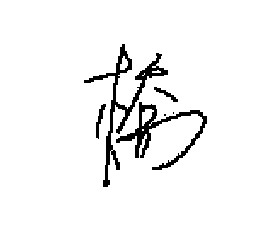

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #387 (True).


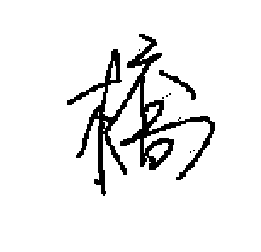

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #388 (True).


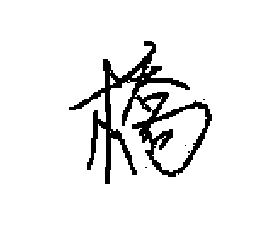

Successfully read #389 (True).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


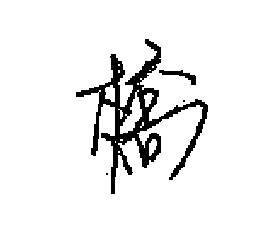

Successfully read #390 (True).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


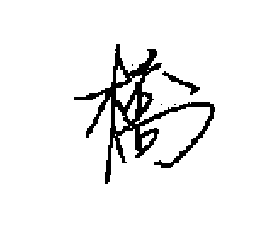

Successfully read #391 (True).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


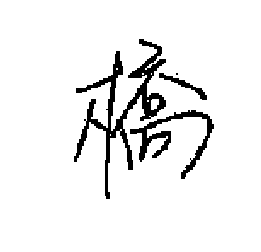

Successfully read #392 (True).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


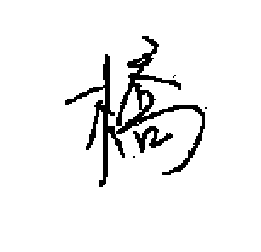

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #393 (True).


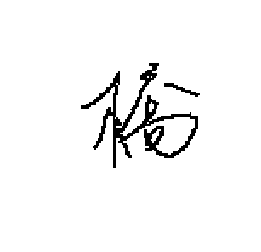

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #394 (True).


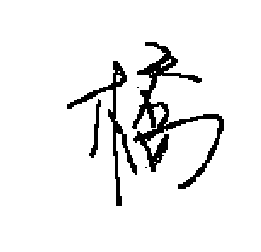

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #395 (True).


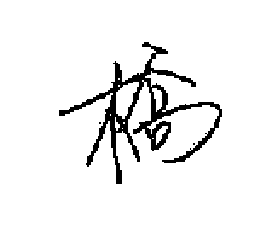

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #396 (True).


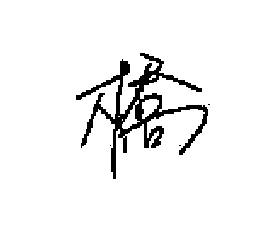

Successfully read #397 (True).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


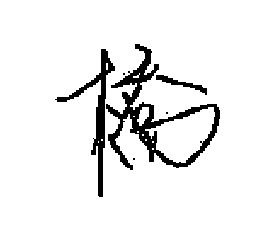

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #398 (True).


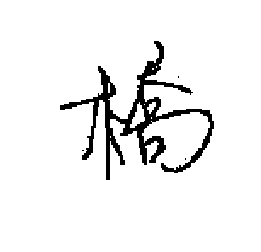

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #399 (True).


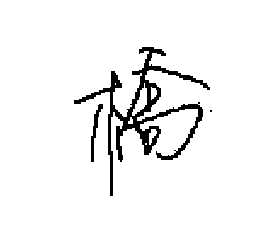

Successfully read #400 (True).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


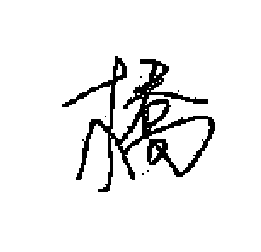

Successfully read #401 (True).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


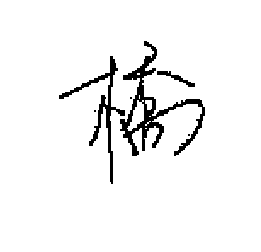

Successfully read #402 (True).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


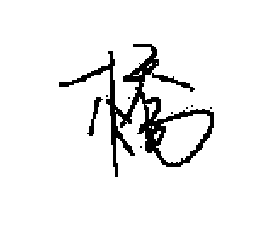

Successfully read #403 (True).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


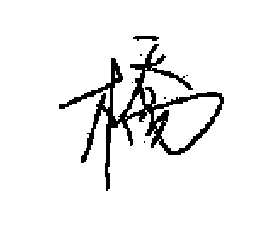

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #404 (True).


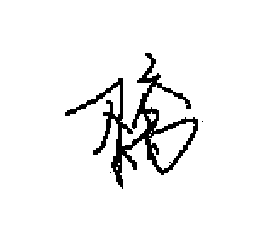

Successfully read #405 (True).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


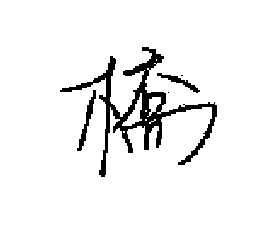

Successfully read #406 (True).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


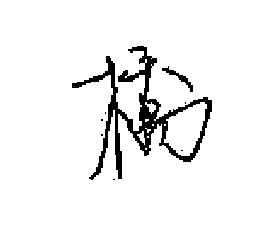

Successfully read #407 (True).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


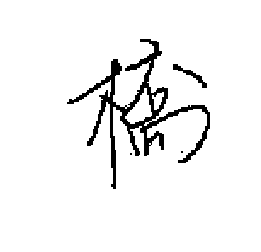

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #408 (True).


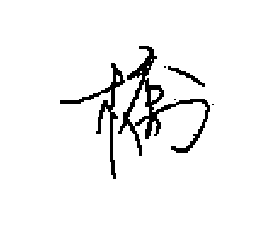

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #409 (True).


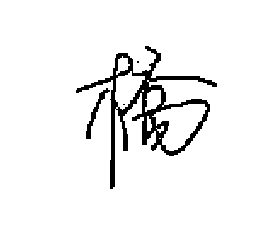

Successfully read #410 (True).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


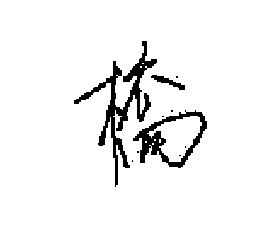

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #411 (True).


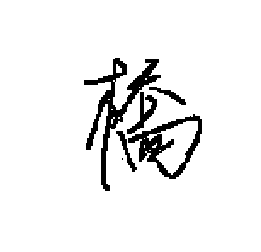

Successfully read #412 (True).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


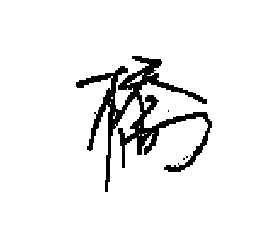

Successfully read #413 (True).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


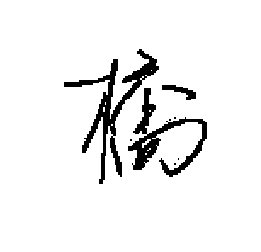

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #414 (True).


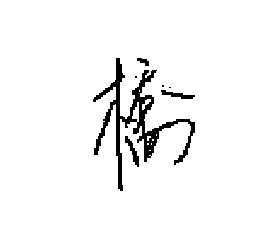

Successfully read #415 (True).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


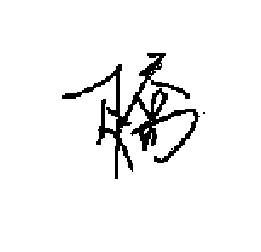

Successfully read #416 (True).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


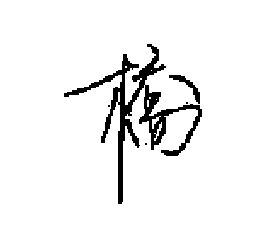

Successfully read #417 (True).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


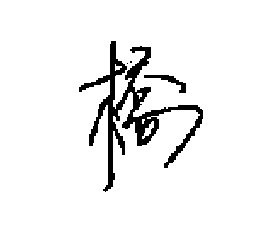

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #418 (True).


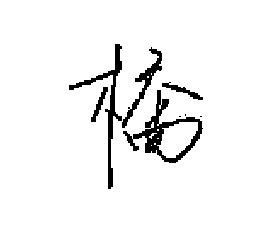

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #419 (True).


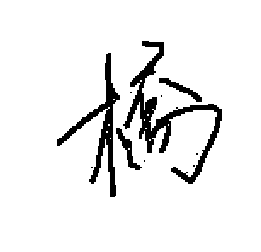

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #420 (True).


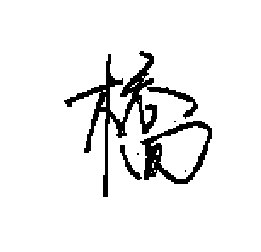

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #421 (True).


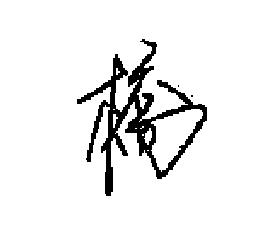

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #422 (True).


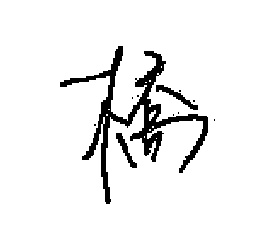

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #423 (True).


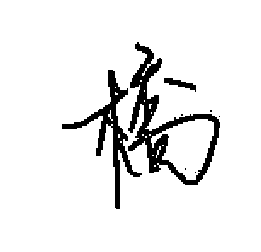

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #424 (True).


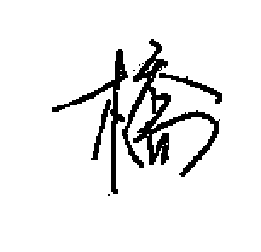

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #425 (True).


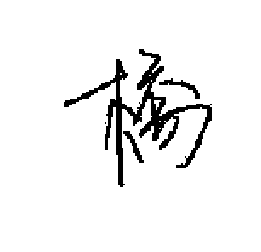

Successfully read #426 (True).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


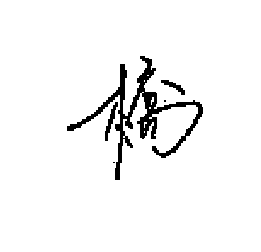

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #427 (True).


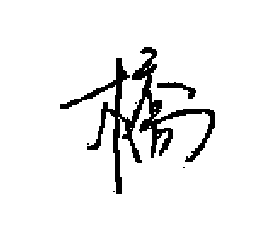

Successfully read #428 (True).


(128, 128)
bool
16384
<class 'numpy.ndarray'>


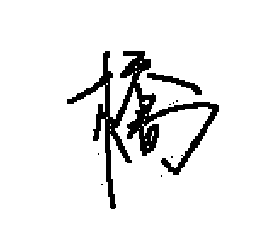

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #429 (True).


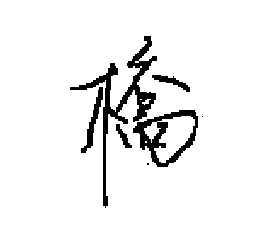

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #430 (True).


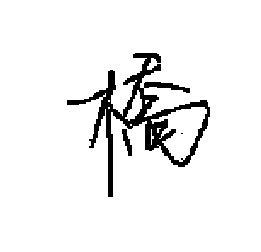

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #431 (True).


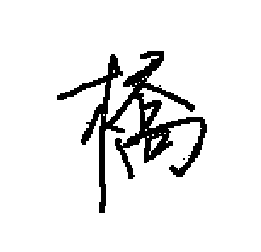

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #432 (True).


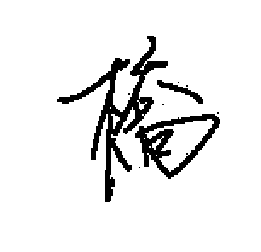

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #433 (True).


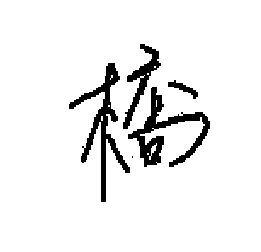

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #434 (True).


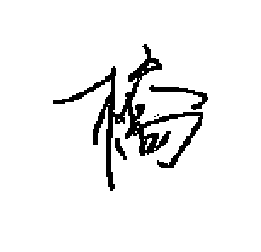

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #435 (True).


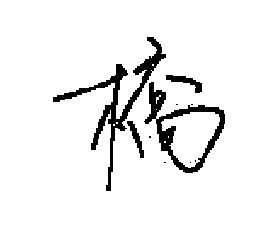

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #436 (True).


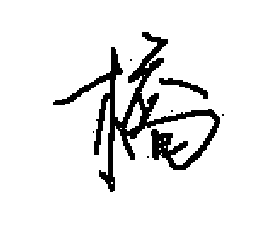

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #437 (True).


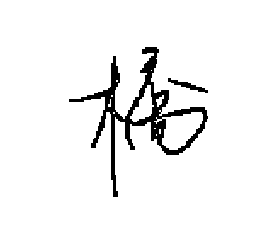

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #438 (True).


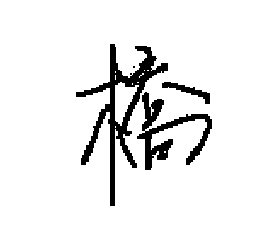

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #439 (True).


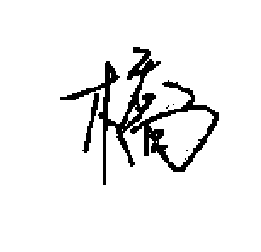

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #440 (True).


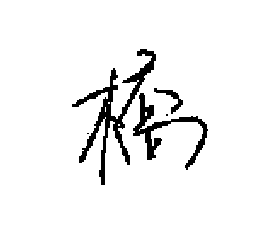

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #441 (True).


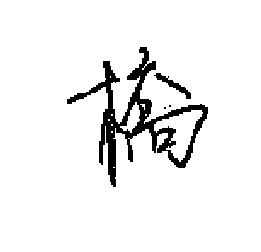

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #442 (True).


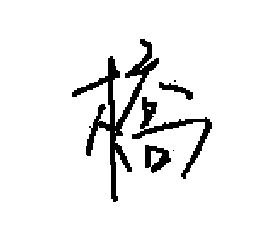

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #443 (True).


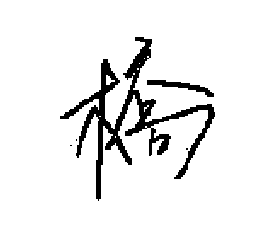

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #444 (True).


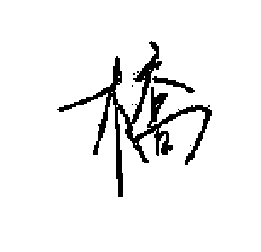

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #445 (True).


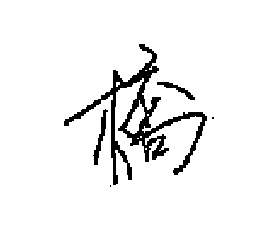

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #446 (True).


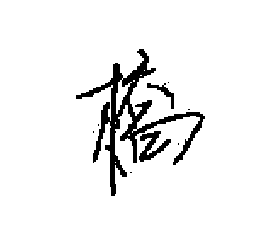

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #447 (True).


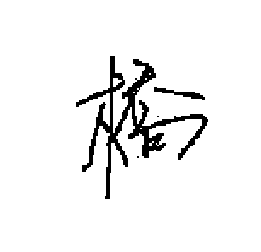

(128, 128)
bool
16384
<class 'numpy.ndarray'>


Successfully read #448 (True).


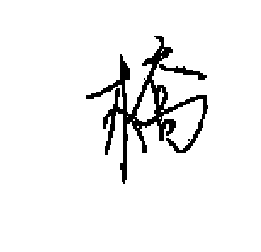

Dataset successfully imported.


(448, 16385)


In [ ]:
inputDataset()

Image to csv:
0.0 1:1 2:1 3:1 4:1 5:1 6:1 7:1 8:1 9:1 10:1 11:1 12:1 13:1 14:1 15:1 16:1 17:1 18:1 19:1 20:1 21:1 22:1 23:1 24:1 25:1 26:1 27:1 28:1 29:1 30:1 31:1 32:1 33:1 34:1 35:1 36:1 37:1 38:1 39:1 40:1 41:1 42:1 43:1 44:1 45:1 46:1 47:1 48:1 49:1 50:1 51:1 52:1 53:1 54:1 55:1 56:1 57:1 58:1 59:1 60:1 61:1 62:1 63:1 64:1 65:1 66:1 67:1 68:1 69:1 70:1 71:1 72:1 73:1 74:1 75:1 76:1 77:1 78:1 79:1 80:1 81:1 82:1 83:1 84:1 85:1 86:1 87:1 88:1 89:1 90:1 91:1 92:1 93:1 94:1 95:1 96:1 97:1 98:1 99:1 100:1 101:1 102:1 103:1 104:1 105:1 106:1 107:1 108:1 109:1 110:1 111:1 112:1 113:1 114:1 115:1 116:1 117:1 118:1 119:1 120:1 121:1 122:1 123:1 124:1 125:1 126:1 127:1 128:1 129:1 130:1 131:1 132:1 133:1 134:1 135:1 136:1 137:1 138:1 139:1 140:1 141:1 142:1 143:1 144:1 145:1 146:1 147:1 148:1 149:1 150:1 151:1 152:1 153:1 154:1 155:1 156:1 157:1 158:1 159:1 160:1 161:1 162:1 163:1 164:1 165:1 166:1 167:1 168:1 169:1 170:1 171:1 172:1 173:1 174:1 175:1 176:1 177:1 178:1 179:1 180:1 181:1 182:1 183:1 184:1 185:1 186:1 187:1 188:1 189:1 190:1 191:1 192:1 193:1 194:1 195:1 196:1 197:1 198:1 199:1 200:1 201:1 202:1 203:1 204:1 205:1 206:1 207:1 208:1 209:1 210:1 211:1 212:1 213:1 214:1 215:1.0 216:1 217:1 218:1 219:1 220:1 221:1 222:1 223:1 224:1 225:1 226:1 227:1 228:1 229:1 230:1 231:1 232:1 233:1 234:1.0 235:1 236:1 237:1 238:1 239:1 240:1 241:1 242:1 243:1 244:1 245:1 246:1 247:1 248:1 249:1 250:1 251:1 252:1 253:1 254:1 255:1 256:1 257:1 258:1 259:1 260:1 261:1 262:1 263:1 264:1 265:1 266:1 267:1 268:1 269:1 270:1 271:1 272:1 273:1.0 274:1 275:1 276:1 277:1 278:1 279:1.0 280:1 281:1 282:1 283:1 284:1 285:1 286:1 287:1 288:1 289:1 290:1 291:1 292:1 293:1 294:1 295:1.0 296:1.0 297:1.0 298:1 299:1 300:1 301:1 302:1 303:1 304:1 305:1 306:1 307:1 308:1 309:1 310:1 311:1 312:1 313:1 314:1 315:1 316:1 317:1 318:1 319:1 320:1 321:1 322:1 323:1 324:1 325:1 326:1 327:1 328:1 329:1 330:1 331:1 332:1 333:1 334:1 335:1 336:1 337:1.0 338:1.0 339:1 340:1.0 341:1 342:1 343:1.0 344:1 345:1 346:1 347:1 348:1 349:1 350:1.0 351:1 352:1 353:1 354:1 355:1 356:1.0 357:1 358:1.0 359:1.0 360:1.0 

In [9]:
randomShuffle()

                                                     0
304  1.0 1:1 2:1 3:1 4:1 5:1 6:1 7:1 8:1 9:1 10:1 1...
187  0.0 1:1 2:1 3:1 4:1 5:1 6:1 7:1 8:1 9:1 10:1 1...
226  1.0 1:1 2:1 3:1 4:1 5:1 6:1 7:1 8:1 9:1 10:1 1...
364  1.0 1:1 2:1 3:1 4:1 5:1 6:1 7:1 8:1 9:1 10:1 1...
60   0.0 1:1 2:1 3:1 4:1 5:1 6:1 7:1 8:1 9:1 10:1 1...


Successfully shuffled.


Csv file test and train are created under current working directory.

In [13]:
gridSearch()

In [14]:
SVMtrain()

In [17]:
predict()